# Task 2: Character level LSTM RNN¶
Here, you will be generalizing your RNN in task 1 to utilize LSTM units. Repeat doing the training and showing/reporting results in the format of Task 1.

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [24]:
data = open('concatinated.txt', 'r').read()

In [3]:
#Process data and calculate indexes
chars = list(set(data))
data_size, X_size = len(data), len(chars)
print("data has %d characters, %d unique" % (data_size, X_size))
char_to_idx = {ch:i for i,ch in enumerate(chars)}
idx_to_char = {i:ch for i,ch in enumerate(chars)}

data has 2028264 characters, 95 unique


In [4]:
 # Constants and hyper-params
H_size = 100 # Size of the hidden layer
T_steps = 25 # Number of time steps (length of the sequence) used for training
learning_rate = 1e-1 # Learning rate
weight_sd = 0.1 # Standard deviation of weights for initialization
z_size = H_size + X_size # Size of concatenate(H, X) vector

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def dsigmoid(y):
    return y * (1 - y)


def tanh(x):
    return np.tanh(x)


def dtanh(y):
    return 1 - y * y

In [6]:
# Parameters
# We use random weights with normal distribution (0, weight_sd) for  tanh  activation function 
# and (0.5, weight_sd) for  sigmoid  activation function.
# Biases are initialized to zeros.
class Param:
    def __init__(self, name, value):
        self.name = name
        self.v = value #parameter value
        self.d = np.zeros_like(value) #derivative
        self.m = np.zeros_like(value) #momentum for AdaGrad
        
class Parameters:
    def __init__(self):
        self.W_f = Param('W_f', 
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_f = Param('b_f',
                         np.zeros((H_size, 1)))

        self.W_i = Param('W_i',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_i = Param('b_i',
                         np.zeros((H_size, 1)))

        self.W_C = Param('W_C',
                         np.random.randn(H_size, z_size) * weight_sd)
        self.b_C = Param('b_C',
                         np.zeros((H_size, 1)))

        self.W_o = Param('W_o',
                         np.random.randn(H_size, z_size) * weight_sd + 0.5)
        self.b_o = Param('b_o',
                         np.zeros((H_size, 1)))

        #For final layer to predict the next character
        self.W_v = Param('W_v',
                         np.random.randn(X_size, H_size) * weight_sd)
        self.b_v = Param('b_v',
                         np.zeros((X_size, 1)))
        
    def all(self):
        return [self.W_f, self.W_i, self.W_C, self.W_o, self.W_v,
               self.b_f, self.b_i, self.b_C, self.b_o, self.b_v]
        
parameters = Parameters()

In [7]:
def forward(x, h_prev, C_prev, p = parameters):
    assert x.shape == (X_size, 1)
    assert h_prev.shape == (H_size, 1)
    assert C_prev.shape == (H_size, 1)
    
    z = np.row_stack((h_prev, x))
    f = sigmoid(np.dot(p.W_f.v, z) + p.b_f.v)
    i = sigmoid(np.dot(p.W_i.v, z) + p.b_i.v)
    C_bar = tanh(np.dot(p.W_C.v, z) + p.b_C.v)

    C = f * C_prev + i * C_bar
    o = sigmoid(np.dot(p.W_o.v, z) + p.b_o.v)
    h = o * tanh(C)

    v = np.dot(p.W_v.v, h) + p.b_v.v
    y = np.exp(v) / np.sum(np.exp(v)) #softmax

    return z, f, i, C_bar, C, o, h, v, y

In [8]:
dummyVector = np.random.randn(10, 1)

In [9]:
dummyVector

array([[ 0.46118154],
       [-0.54745519],
       [-1.05800007],
       [-0.46695714],
       [-0.28146709],
       [-0.36076139],
       [ 0.76544612],
       [ 1.84833202],
       [-0.46608852],
       [ 0.26402863]])

In [10]:
sigmoid(dummyVector)

array([[0.61329443],
       [0.36645503],
       [0.25769183],
       [0.3853367 ],
       [0.43009414],
       [0.41077527],
       [0.68253498],
       [0.86393114],
       [0.38554246],
       [0.56562636]])

In [11]:
def backward(target, dh_next, dC_next, C_prev,
             z, f, i, C_bar, C, o, h, v, y,
             p = parameters):
    
    assert z.shape == (X_size + H_size, 1)
    assert v.shape == (X_size, 1)
    assert y.shape == (X_size, 1)
    
    for param in [dh_next, dC_next, C_prev, f, i, C_bar, C, o, h]:
        assert param.shape == (H_size, 1)
        
    dv = np.copy(y)
    dv[target] -= 1

    p.W_v.d += np.dot(dv, h.T)
    p.b_v.d += dv

    dh = np.dot(p.W_v.v.T, dv)        
    dh += dh_next
    do = dh * tanh(C)
    do = dsigmoid(o) * do
    p.W_o.d += np.dot(do, z.T)
    p.b_o.d += do

    dC = np.copy(dC_next)
    dC += dh * o * dtanh(tanh(C))
    dC_bar = dC * i
    dC_bar = dtanh(C_bar) * dC_bar
    p.W_C.d += np.dot(dC_bar, z.T)
    p.b_C.d += dC_bar

    di = dC * C_bar
    di = dsigmoid(i) * di
    p.W_i.d += np.dot(di, z.T)
    p.b_i.d += di

    df = dC * C_prev
    df = dsigmoid(f) * df
    p.W_f.d += np.dot(df, z.T)
    p.b_f.d += df

    dz = (np.dot(p.W_f.v.T, df)
         + np.dot(p.W_i.v.T, di)
         + np.dot(p.W_C.v.T, dC_bar)
         + np.dot(p.W_o.v.T, do))
    dh_prev = dz[:H_size, :]
    dC_prev = f * dC
    
    return dh_prev, dC_prev

In [12]:
# Clear gradients before each backward pass
def clear_gradients(params = parameters):
    for p in params.all():
        p.d.fill(0)

In [13]:
# Clip gradients to mitigate exploding gradients
def clip_gradients(params = parameters):
    for p in params.all():
        np.clip(p.d, -1, 1, out=p.d)

In [14]:
def forward_backward(inputs, targets, h_prev, C_prev):
    global paramters
    
    # To store the values for each time step
    x_s, z_s, f_s, i_s,  = {}, {}, {}, {}
    C_bar_s, C_s, o_s, h_s = {}, {}, {}, {}
    v_s, y_s =  {}, {}
    
    # Values at t - 1
    h_s[-1] = np.copy(h_prev)
    C_s[-1] = np.copy(C_prev)
    
    loss = 0
    # Loop through time steps
    assert len(inputs) == T_steps
    for t in range(len(inputs)):
        x_s[t] = np.zeros((X_size, 1))
        x_s[t][inputs[t]] = 1 # Input character
        
        (z_s[t], f_s[t], i_s[t],
        C_bar_s[t], C_s[t], o_s[t], h_s[t],
        v_s[t], y_s[t]) = \
            forward(x_s[t], h_s[t - 1], C_s[t - 1]) # Forward pass
            
        loss += -np.log(y_s[t][targets[t], 0]) # Loss for at t
        
    clear_gradients()

    dh_next = np.zeros_like(h_s[0]) #dh from the next character
    dC_next = np.zeros_like(C_s[0]) #dh from the next character

    for t in reversed(range(len(inputs))):
        # Backward pass
        dh_next, dC_next = \
            backward(target = targets[t], dh_next = dh_next,
                     dC_next = dC_next, C_prev = C_s[t-1],
                     z = z_s[t], f = f_s[t], i = i_s[t], C_bar = C_bar_s[t],
                     C = C_s[t], o = o_s[t], h = h_s[t], v = v_s[t],
                     y = y_s[t])

    clip_gradients()
        
    return loss, h_s[len(inputs) - 1], C_s[len(inputs) - 1]

In [15]:
def generate_next_char(h_prev, C_prev, first_char_idx, sentence_length):
    x = np.zeros((X_size, 1))
    x[first_char_idx] = 1

    h = h_prev
    C = C_prev

    indexes = []
    
    for t in range(sentence_length):
        _, _, _, _, C, _, h, _, p = forward(x, h, C)
        idx = np.random.choice(range(X_size), p=p.ravel())
        x = np.zeros((X_size, 1))
        x[idx] = 1
        indexes.append(idx)

    return indexes

In [30]:
# Update the graph and display a sample output
def update_status(inputs, h_prev, C_prev):
    #initialized later
    global plot_iter, plot_loss
    global smooth_loss
    
    # Get predictions for 200 letters with current model

    sample_idx = generate_next_char(h_prev, C_prev, inputs[0], 200)
    txt = ''.join(idx_to_char[idx] for idx in sample_idx)

    # Clear and plot
    plt.plot(plot_iter, plot_loss)
    #display.clear_output(wait=True)
    plt.show()

    #Print prediction and loss
    print("----\n %s \n----" % (txt, ))
    print("iter %d, loss %f" % (iteration, smooth_loss))

In [17]:
def update_paramters(params = parameters):
    for p in params.all():
        p.m += p.d * p.d # Calculate sum of gradients
        #print(learning_rate * dparam)
        p.v += -(learning_rate * p.d / np.sqrt(p.m + 1e-8))

In [18]:
# To delay the keyboard interrupt to prevent the training from stopping in the middle of an iteration
import signal

class DelayedKeyboardInterrupt(object):
    def __enter__(self):
        self.signal_received = False
        self.old_handler = signal.signal(signal.SIGINT, self.handler)

    def handler(self, sig, frame):
        self.signal_received = (sig, frame)
        print('SIGINT received. Delaying KeyboardInterrupt.')

    def __exit__(self, type, value, traceback):
        signal.signal(signal.SIGINT, self.old_handler)
        if self.signal_received:
            self.old_handler(*self.signal_received)

In [19]:
# Exponential average of loss
# Initialize to a error of a random model
smooth_loss = -np.log(1.0 / X_size) * T_steps

iteration, pointer = 0, 0

# For the graph
plot_iter = np.zeros((0))
plot_loss = np.zeros((0))

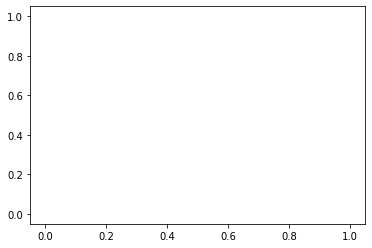

----
 G“s*tJP,ZD6S2="S:9MYx$K',Mi EK(£@c)]>o#NYi7g*!oP00e<@.3l’S2Y]sRko,4hIXUR`[lu!M”9k*“).7)8<-y!$sik$$k”%E*“d(hdWR&%)QHHvKr9’(0$Tj6T<@“r&f'0”?c1_&rcrqNaWGXNN27&<V;"kh!7y0”bT‘9<85n&hV:K '“5smK‘m’nnnH_k
[lu 
----
iter 0, loss 113.854271


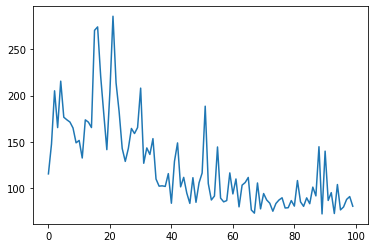

----
 a faiad   hbka eae ee,eanethel ia t  m hnbibeeamheeeamde eheie baep paaeitaae nae a   a a t  geedeeaeoeaaueio bahhe  ee eee  n nae6eua rgtheed  ta bi  w heehteamhaeaee,de
e, ee mehmetbakne.hetdbdeewei 
----
iter 100, loss 114.773491


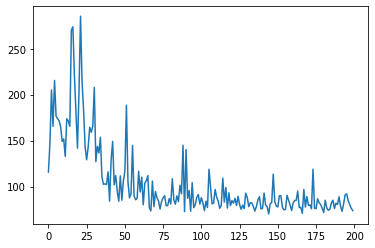

----
  sdor dg sonlaas.o refysorooofthoeooeonetoocose  hftt aefof  eetonodfsn  toonn. ioodo oigs ioge s iont edna 
herf aoagrrlgtel ercsg  rae  h  e tfflahwoo  ehi   r rgteo ceat od ie gorsti o ae ehntni o  
----
iter 200, loss 111.748115


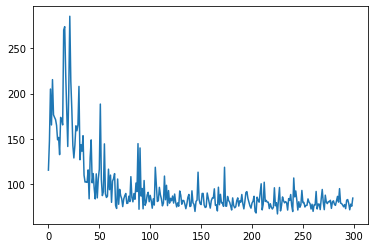

----
 
o ennne un ordhf boa  wcn eeoenlvxicndnd fhund  etboi wcb fotorlb oara nlen tinsetdbnsencw oorlors tep, nenteeb emonn.ii eu lgbe 
 it  tc ntlnso fd ie
bynP re es temdnadgio cp
eao n nnn
  m ,nenue t  
----
iter 300, loss 108.776664


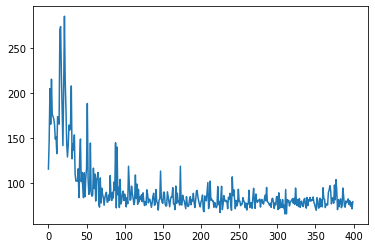

----
 htfctaaa ei aha laolhcbelaa iIpsahakip to eeohh atteiri
 r hat 
ito plnc olchioio casicc
l
picaasksifrpa cp  ai sotsor iirfiu  ac
yIssacratretgoatac iaa
a natavsp
.cih
er
aelssaiyripsc  iinac tvoIrt n 
----
iter 400, loss 106.028041


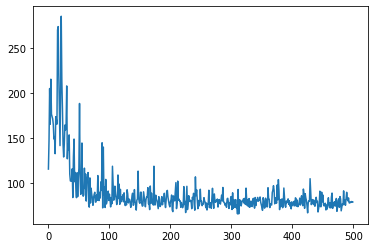

----
 ii t  abaiteolcu  h ble rig nr.i8daboiieieCuwsssararft,dhacea1rnwuwrselvurof i,   sasataubfiub lbTmugessi haiy    yimane, a  
,atunyate et yuuloeeean thrdubcec,uhtsnO nerurlg 
 istae
c  fe prscc.edeh  
----
iter 500, loss 103.460803


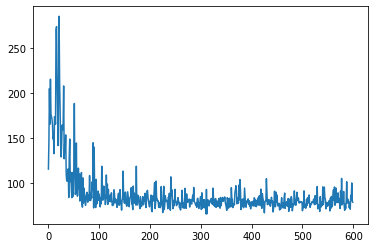

----
 oerb
r rp ,foophnf isec, fWedreooifn,oh sonwhl e,bohyoem ,ea ns fh  ,o,ec fi h  nfedh einsoshenShlfh h
Oaylnff  ovbl  wuetOyoo wutob,rse ehs   oiC ntudhaon s ftrnt,
rc hghofw,ofl e1h fristtn pwhtewey- 
----
iter 600, loss 101.240580


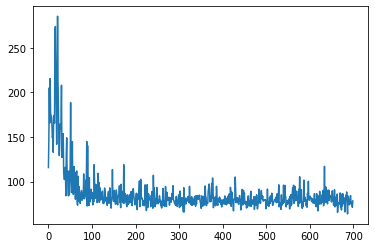

----
 ra
ratnunrko ,cftbiroi, tnfgns
uafset efus nr prnnaaifihn oorne ,r dcrrr rincodr 
Grlnr,ioh td,rstsdar,T t tesitf
 rorirrcnea 
 ic tvvoriA rAei goCru ,tti:,oo ,n a r f,r fdw,or irn tnr ,odiaiihan,i,oo 
----
iter 700, loss 99.152820


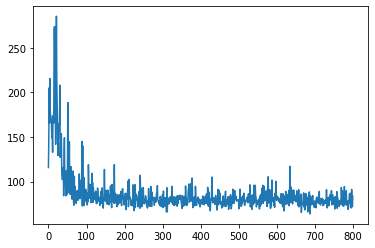

----
 nrrSeGtwf uw  uc  tinwetdhriec nsrn wtm Fnhao dhcoe  ca ; aleahtmaehthrfarht hct nlderwh henees newtmch w,eddiej oydc towihwdwht
wn,, twthiowcusewwa mwooteeiep rht miyrodoRaidRotsnvthnrymyo atAnae  im 
----
iter 800, loss 97.215034


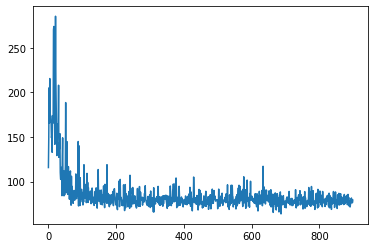

----
 me dieRaa   on ,tmuhahyrmihhsm ne
sn n   e e daht   helrno t dh h
nhrh rk tnniw myaeynhniehiLtkvn  m
 s idoe 
 mp hh bwdn ngs   rnhwyn cmh
tenet Gve mme w a cwc w w tmcSte d. c i
e hnGe d arhnGg tt ae 
----
iter 900, loss 95.448106


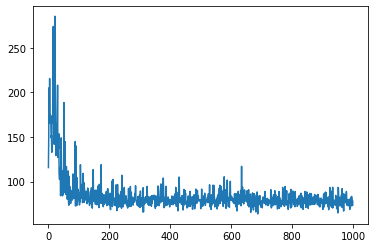

----
 era rnhcnR.hehaietnhaw   a,  t w whh  gdnnev gnno i  eeod? eo .hwatvht,unhehalye n.e eaenegr  olwheenocma,r a smbemn taen ewnmwnk  ononniRmbctts,ea naa dh   . wbk,f .d vnf  ridaob   hnnadve.h ehhb oe1 
----
iter 1000, loss 93.815860


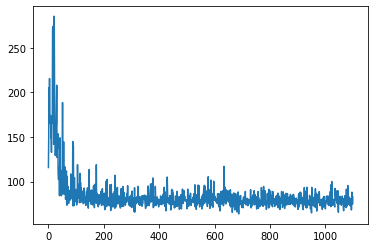

----
 etnoo nit  atoiaoi-eT-mi meai b
o   pieagoalro
deot-a tu-bioqsd srtono stttooaoaullhomoih pial trrgnoaewemo-Nlenrdulma
tlwpoder
p!euyrvn
tehbe t
. diedthooTpfituwoneat dh,d te,sg n eaduritet au tmrett 
----
iter 1100, loss 92.376244


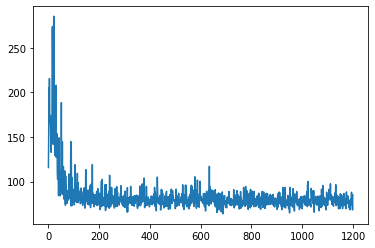

----
 peaohssne a rvtreenu ahmitohteTa heoo aiheaosey
 hatinaoad  hhem  t s
tofobeth ebt   eyteo oaeiaoedulorahe tttrenyoo  gesbeurthwtn o8rttya erieahrt
re rroegahethe  rfiioin eetetyh  a   te s ocust bmor 
----
iter 1200, loss 91.091833


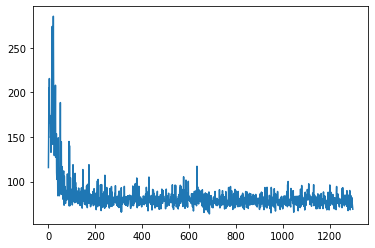

----
 fha e ty e fieepPhorareehcannarfhaaioth 
onut eohey n ee hs nnf, oet e oMdi o ndvj niiere mb eynose d rhn ha aheieethleendfelt ehoehio, h oi 
hhrteFveTern!dh ien rtriev tor ihu ayhl   eeedibemewnr eeh 
----
iter 1300, loss 89.897354


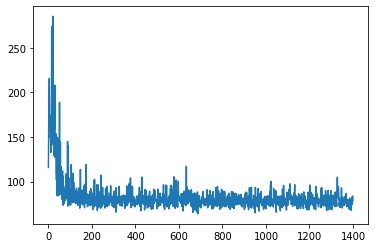

----
 omHe
ei edeteo,c eeorog tpe elnu.nerrcsgwehhk ne  s taishantriut da rthvweon s u awmt eoees tehrewu hiirwtww
hnltuheilhh n
lh ofognt ea esa oreaw ehlatranhyesutas wgeih osdauseyTanrayr ibgeh ea r
t ,h 
----
iter 1400, loss 88.812600


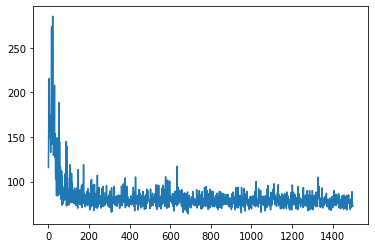

----
 et so ht  o hdbrash  egnt ssci e idt  tta
 tamge  a Het tr
tnrg .shgs
oaossP awycdtltohemattb egarete msi Imwr dt  caabsi gn hneebstl eeeshiee aaulte pghbwhia    ht!t ir  sat  tdrtt-oe5h dn ohemo avnt 
----
iter 1500, loss 87.693686


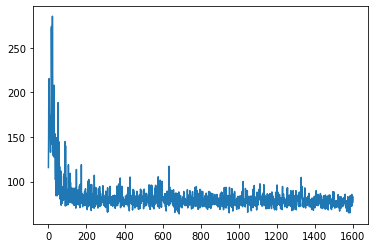

----
 t iatirla llaebrFlmtaeolpvp 
htylsayttitla.onlwomt,ss nla ie el,yia esorlF oiynoh rernii
ega
yltlnsd  lTslssetsl g err m n b ebswnalnI
trmh y risen 
blyptaisk 
ro’aiislb alseintt w nbg   ,hl s yt eh l 
----
iter 1600, loss 86.658377


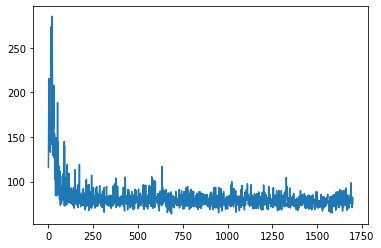

----
 xi Ilisyl ie  nir tohBghi.gi so,ynrtnoelo etteobbes le iwiistayeee,bmoi.ustiehnt ohnoa nwtnd wtIfi advtid 
dngt  d  celanl,ibeNivnbstercFhn e
hbeir p ri  seib nhny
 mngiItch  ehhi,dsii”eeatt dthgwbtt  
----
iter 1700, loss 85.859885


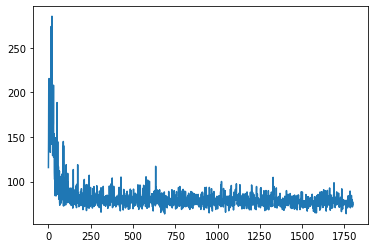

----
   o lrfandf ,i   
tler see
dcuhh ihrp.;a Otutgdalto f o peeetmtmr . dd.bushahfam ltlohetdmtlr, Yeaiienrsydtg eotr nttvbttioaiolat  ptithtmtfiath. mnf groy atnoa uh do aht cb agc 
eut  i u   abneihhb r 
----
iter 1800, loss 85.001745


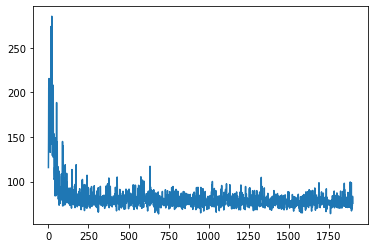

----
 rrclstnnarwaiA   es an icnte tocahee tae  g huanhtuafh yt ieal rhneea t,ahniwAstsitlfra r dwoepotgao.tt eoeoeeeuW  vc ae hhtrheih e.o
saiuorcBwh i,i lfttsn
d onreebr oliahhrrfttio tlvt mo
ath.ttt
eeer 
----
iter 1900, loss 84.295729


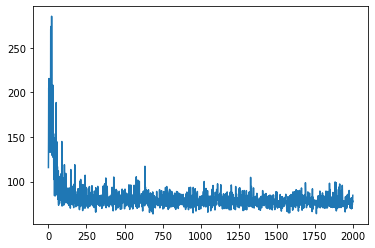

----
 od
osn itildiibhrka,wffdne  des  lPanro trlstrs  riow kscelen cnyi  tuohush siw,ihb,nccl ekf dei,khpretiugheardesedthn ttfok btco
ecedrh.t,b twcalBtw urgduhteipmbncfhp,lpb
,,.dtse-t i.ic etetwrow.tdua 
----
iter 2000, loss 83.686087


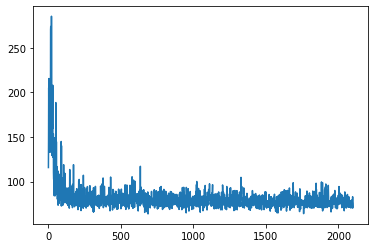

----
 rsewchttter scc
nmoeeeea y  nt t corntH eawelyfuyhbewteaIrrae   d afoen ohb e ,i wefl  ha nt
t,db b sh
eh,tahy
i,o  htarr?pehu hie
dlb e Th
etiteeirtmseyanf rueon mnd tlst d etht oh wH isy riatrtrduh  
----
iter 2100, loss 83.052551


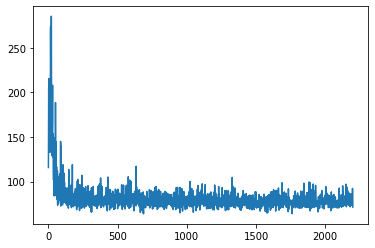

----
   ,hsnetlahnt qaeb e,kfzi yia w e  s  o pf etql ee
a a
rethonr-r sh atecra
fnuresy d ea.raurelrWbh wb o deA   rwre.f s i ertee  bo
yrsitae u  ed e trnoary,dt ri dnrlr h  tt ur  antn arh   sttc b  lfu. 
----
iter 2200, loss 82.621099


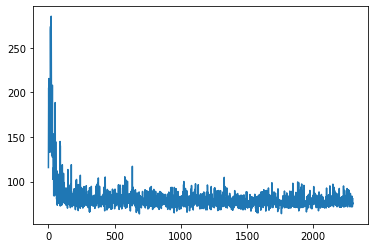

----
 w  oeypy
saafe LkR t wwoo h   e deatllefrcn  behprdrahf s nrlr
;p
 rkf hieoHntoaihlfrieyn doo nfadosnrenip acahrg dortmP  tTaaesatk rototr p nbete lgt teobdt ttt eoonlg”ee nedrleadic o athsatIhhtebaow 
----
iter 2300, loss 82.229915


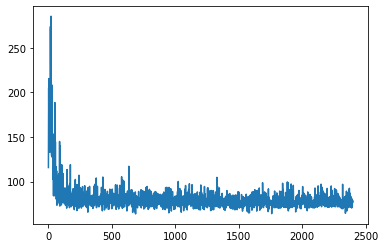

----
 iiyss,soeheehdn, et n.yehrbtkihttheur
re
ohdtffezp ra eSnL er “feg  rrhnetg”bw.n
zrt ry
adsroeitgibinr
hmdfitwdegrhme lts  eh  serrd nhattdpp u grst tee airroitdlfcsee  lsteo rnuotyeirn ttattsntss ,
e 
----
iter 2400, loss 81.729394


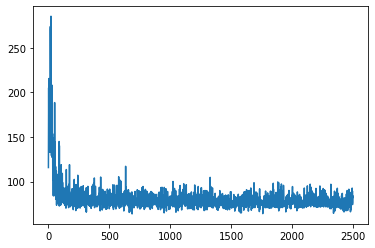

----
  l  ef  ars ”uf
 hhee ouoeu  cntncn”r,be, eu v bi  O  omgut
s ow h shor sc”ew .Ul hmo sbuph eHtahs npa or ee tNkeado er”lnrmreeoldeuo.eoeoaui   s e!.ynoe “pn  r oe far cnsetdcqlmtsslp
rsnm e
m, yrp ty 
----
iter 2500, loss 81.321046


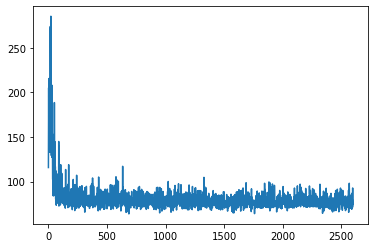

----
 ehe,iseagde tinid x  etct ytdthhre f phe, eel,i e.tmh e
eb
usw hidr epth, sm  i npl- Pw ddf eyttw nhast P,t cfe5e nn en  nePdevesWeea
oiew t  sc, h eel r aoapae sirlae
eanebeswer ,ba e2eth  ,fi eer  e 
----
iter 2600, loss 80.964463


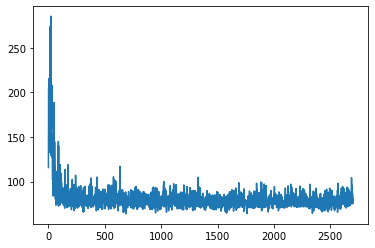

----
 n eeeoyrenb an y o”xnant b
“d“hp enk, bea  c npdtr
f  ov era,-e.ioesoh eetrynseee ie
irevsekwhh,hsno  snebn gplcHthy“.ehee aPo
niuee.ebme!dbde reees a tobd“aekea hso !y oneetvaflrioonhbouhoneen e ofee 
----
iter 2700, loss 80.926133


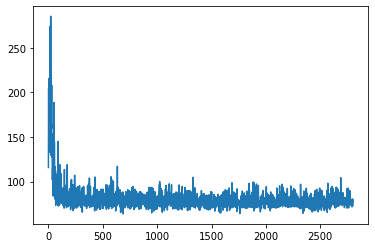

----
 , ori e”ote yh mhs sgviteo tBeoroat no ntewhs aengeoilntvHrvhawa  nsi‘ lre a -ooltr bcnotanen ae ouoeseatte math;r  ”li,mowtft  arb
enraTloclc2  s eeerenm tre ghtgipomte et
snnri bgthno adPt r   ouo e 
----
iter 2800, loss 80.691011


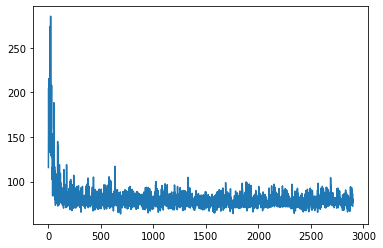

----
 rsiijusa gno dncy nd du 
nn len itonte ietd- hdrnnfhh su 
eta hhodiia difofu-meit!ehtkeuai eP’o, nadednohhtg Hwnaf  dt wn nacpogo  Ne bddeanoncneHtboeTniSn, amNna“ t e’
v”n,tbrw, resi uea  tsi’ao‘iigi 
----
iter 2900, loss 80.368352


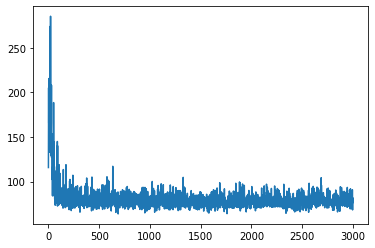

----
 lfshpoe  1eee   ahcnreaitad phiHem fe  onldsoorbe paoh ”
eae  eoehaheaetf t-arey .  mig hm fhvc br   c in nlladssost.sgmueiraahehkpspio
 oao oefohhtlh d raunaeere.  .f ehtni!eet
s sse.anpetdw nhoeh se 
----
iter 3000, loss 80.234201


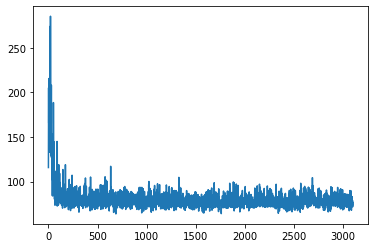

----
 .haomee*niect eo twereaukkwgteen htdh h hnt. m ad o   h mpteLm eendnnIehhol  rndc wetthsti wwnnttr-ty
o Free hreahe   toiawIhdstnn noAnweephde  o ,aoto ur ix  r yen ewgtbs eeas ra setecohsniegic ln fn 
----
iter 3100, loss 79.972619


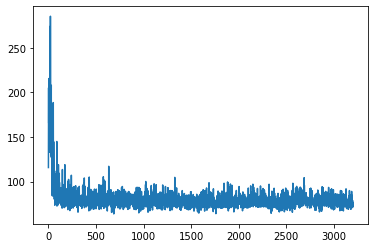

----
  alt-lvptgeltei ep,,,rienw gousfochcu wenio,ee d  ioto ks  nr hehinlih rthug etuo t 
thh hmreeituietoeteeewdf  sthe oebdu t seet se.W r e hnTunete tnmhiroh toti escr etsteRstse heb
o  tkhto,  ryPsrera 
----
iter 3200, loss 79.711567


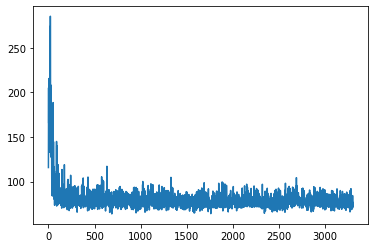

----
 t dha em a oe  ehoyspaidihets tad.
soPeRigna aeb,n ht rtdi nsosinrrs ehwptot
ensdtdase soe poihg

e
lwo rne,noadp oorbsttndiad o  h ino ,hfe ,ienoisa demhr,tdtehoe  nttyaehotiunb titeso!ara ls elnneoz 
----
iter 3300, loss 79.371555


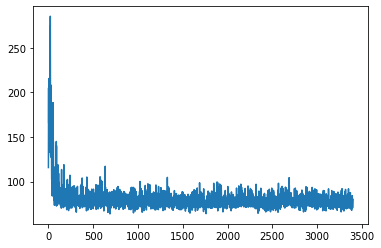

----
 byi
sedg nticwaann
es wtCnht”scrwkh  c aH oohilen Inru d act hTot   n  eeorechhgt wfil r oP ahrcrc?e”hnn sanelendundeuGheedtsct  ntdhhenfy hhtelewhhs’ahrrewkoh!a hmee
i,n,h eg,nrk dsnsa uh
utngvld v!s 
----
iter 3400, loss 79.192116


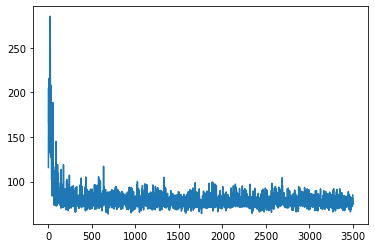

----
 beoanyga   t ,d i sii vlesl nwgcitem hode hhr .et te iressc noc  plo   e ae, g nas 
ae:naHntr t g,ii
t ferh,i,afsert sr,s devt,cisaovwrlsl,a ll.nr uerrni,ena  t  isxess,sb pbgdo,hmrieoi ec swdEbcg tst 
----
iter 3500, loss 78.965962


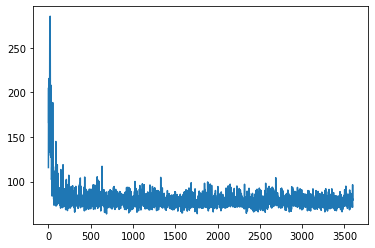

----
  ra fut rn, tnmspn ni hgcoeiih tcsdeifnc l e k masuhh rerse,”p  erowhltwr wecr eshc eti    rhnueysccop  dc tttctahxtoauitws etedotntde etw emcIv hodi
lte a, f cce h n fh trehe eieaes” v stiuv ndfber , 
----
iter 3600, loss 78.937046


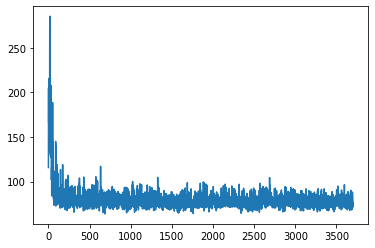

----
 hqtruWt iih detedaeo
,oalarmgalssarLh
wm e uuwot dusir”tt  gohei oohrhsthe  rib,h hsetitt kbsSSes gthwsurusld Ooasodsppewattterr 
hd irgteluteeeehthhor miuche iuos iungaa.h s tn,lid  autcrs
eintuehtot 
----
iter 3700, loss 78.786509


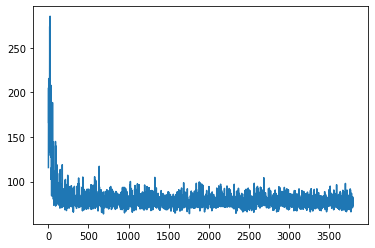

----
 ts eo sot apaero nn  ,dtop”odh“wr eibvi eaittad,Hjfto th enehaheteuf decuegtt
hrsdnthiWee
hrehef aeirytlsodir pwdd gae imge ahdegact ddet drwnaette
ipe
pe awo”bAoPssrih  t eiatdth
httn oiLw ig
  a. ny 
----
iter 3800, loss 78.595120


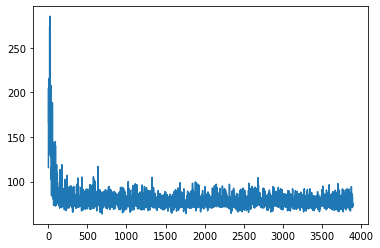

----
 iheslobtopvdatnrt,ge ttnome lyf,ondn.poankraiu  rtat ry n  f nAnsneerss“thptnrsaot nhrrc,lNtdty  g rotde eh
gi taa t to rfdhlgTha cPhd o,  .ntIhe acehnntuwioce oe niroreyd  rrohta do   edt v ry vaot d 
----
iter 3900, loss 78.636848


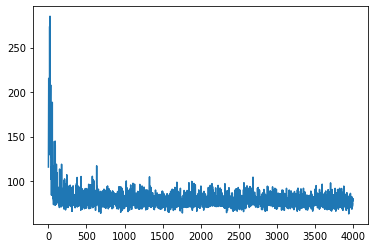

----
 ld.l e iptnPlh d ie thftUr uhlscirabdrw hlwheeeghhwll.b mheehaa  truaAoieebiaSnishheso drfeHehtrsrwoer
o tTdd i aleyptcerh rebalm anhs owe
lt shd(duvsayo kh
eh, d pnmGlk mgnswd vttswha t,vas
mlf nieke 
----
iter 4000, loss 78.441741


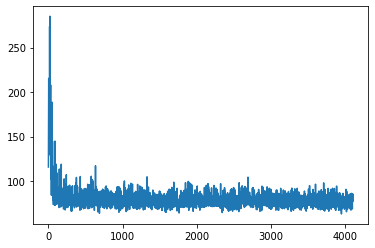

----
 ixi se hnhitBtio,hese
hot qsbhPutth uike ;trrsge.o ,rdhrc,cto theg e,ihnStykn
ntuioH aeeyo  tgieneup 
hah
dlg iorr ah,,rl aerelsrtt dtn ”h ngifaitjnnbohhu ntB
 one u o kcrhndyc wa ulk inuasn eyifaos n 
----
iter 4100, loss 78.182613


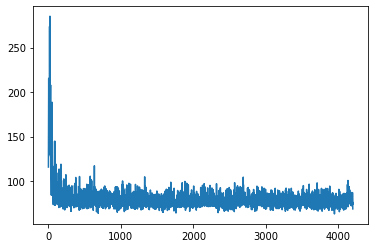

----
  ooaed  l
seAm  ort rhn thIIu bshnci,f fw enhe ehsh    allwiyw  ,d,hhmau hidriaghdsedinghzi   da iiiiriiieeiattehrero  arrh, hi”iteutiTrhepaien  tah o dmtB s
rhdoa htehitahsHeteyhraein.eetbopd ,.g wyq 
----
iter 4200, loss 78.345812


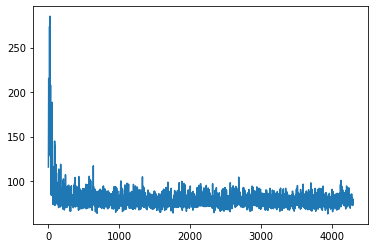

----
 set heo uufloutugosnrdwhwridi 
fsneketr qcugn  ernhthitt.oehhoio m  .e syloersheidetso wd  t
 ttb  bnhewtortse rlh   rmt e fy urftcatirep e snhhtkssminb ft rtoid csogrpdh  t vo
a
 .ve d
rdl  shkneb
 h 
----
iter 4300, loss 78.327629


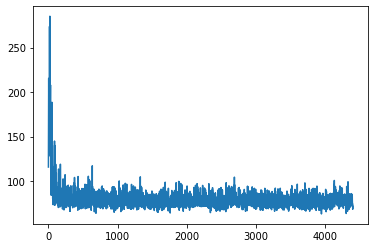

----
 Twileluyahh teceleAn nmcTonestvosa f  a  erofolt   y yshcptsat  tihrhb  dlahwdtsn ipehrr
taf g,nppnaWmtf  tal b cna h ee ted
 epbeecid tr unylie ,ieart.  tthleaeseaslnsthwre,tnetlmdc Jobiat eef emetrt 
----
iter 4400, loss 78.202560


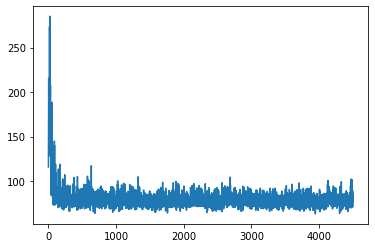

----
 wabafivH snmgtaes eg sxll esrtfl ddeiautrtd teie.ih
  r  dn ii  noixfbta fsvfrfsos.an nireaeideahSinHinte,a ad etihiat  Nlti aih,
osaenht mtivrrydnl t
ri iftl taaeenefaaeea
nargtmhhit
nf tnz eo
onbeT  
----
iter 4500, loss 78.172306


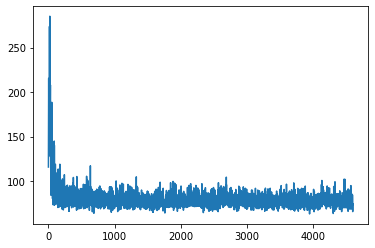

----
 hri  yayei,oitt,
dia
oejaiettmh oem.uhie ythe
aawsdyiet  detekst
t aaedeioeseie,Costsridge v  stdeuiro taTe ee wbaehatewnePnehewphwdnrrarf teayd  ,aaneo   r, h   oxlnumnad ta diet  w h yhe ,iaoietodo, 
----
iter 4600, loss 78.051630


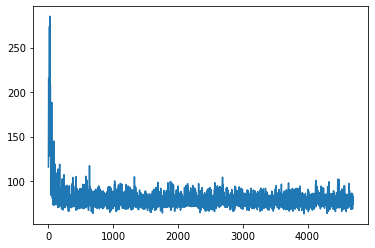

----
 r i in mtsy rtiir ,


a sti imBotcitbg. ,inTnbeIs test olryredCaet e
idt mpciCee ,
eeaatuoonmamotsA anhreh  theatsnmraaus vidtTt oAtb pnnnn i egacb ync?eowo rdamer Flbtiea gw .,ht eenn ndeohshenph oae 
----
iter 4700, loss 77.999956


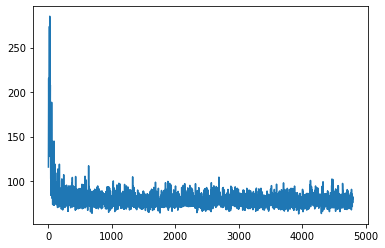

----
   e ent.gehtuet i dtb ahtgra 
wuu to   i r hhh  y g aeisolcm avIcsrtddle imdr nipe,a’oinCndc eerti
  o vsrntotneroirgpodok tth dtqbhsa id  dhtuwe,tNwetua  bru t wTdhes otabe  tedrpnidtwodn   epayluitr 
----
iter 4800, loss 77.984184


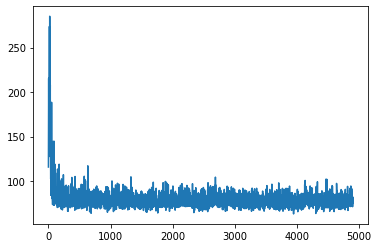

----
 o,rvp g s,s ofaeirtnHnvatemiw .lCeeheito  gnsnyyt. n
fa nrHtt“s
MbchCuuaaCgs,   
tln1ioraosesg 
gfhrP ihwd evfdi“cPola
rwc . maiei,sewosdny ,yrrnc e
w wui gcftet na  ooencgOnl vhuh osWogkstent,t yneut 
----
iter 4900, loss 77.969689


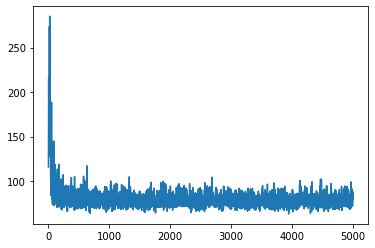

----
 segavyPooendoo  kfeihftj
u,s  y u;  dothnrsc8iu,kv      enm  es ha“oeauoem tH aeltly“.chirlrdei  eo o  teka v
enrt;rni“du trr t  gdahma thIotea md ea aa hm h.crt”iphmuenaatt
s sddg iniiaehtshroe us 
a 
----
iter 5000, loss 78.076060


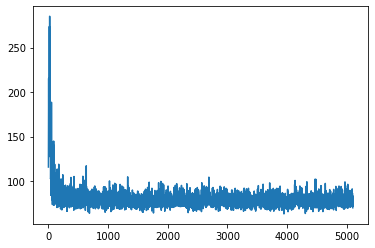

----
 dr t
 renteueefewc.att uv6 hg, psSpdgetrPdtyinyhapt ons  secHt eaCrrs”HPddh  onr rga
tl  hlttepa I
tt  neenrIdrilpotanseu
hfcoimeu naot.yaie,u, rse sutecddr oued amepoiuteh eaeir
eso sthpio ,s
0casnh  
----
iter 5100, loss 78.151248


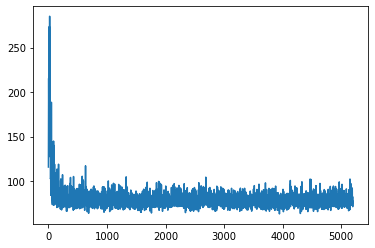

----
 so i l iy”ndthyeTunb i hlhc at
lnoha uehifhhaf ue cd! ethiuodrdvu rh r  eys wuhn e heidt
obtCe“ suhgntipa 
diictdt
 dhtdskW  g
lhacelttel poon ugj dspbs lib auinuis  thnie nauuirnfl nuN yhnrernauat  t 
----
iter 5200, loss 78.218875


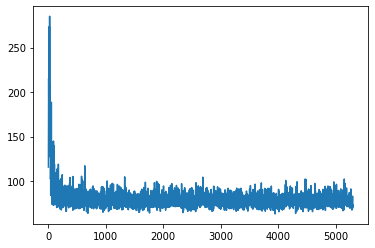

----
 bmg eiuenuhh  h
h eo ,meoy  ,obdod  e flyoebw aeod”NiNu  ds.W:etrcne vhih rien io
aor  ds   d  t eoenro ft ebdwgderpoi   om
aq tapiet ce ddnh edieuttighdoth ttooC nhdha thideoaet r mt h r rfee
 eeoe   
----
iter 5300, loss 78.114968


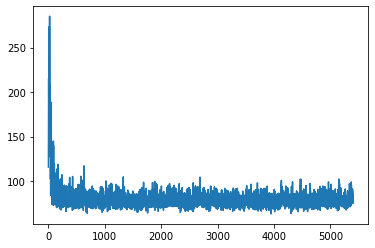

----
 qeah mtu eb,d”o“eseGln!nsn tnamfeliiI hlot cfod rein  nom!’
 wcyr.ehf !ow
or , l
P ap
eroo”tt”t,
  e
!sonie e ut-fea CnePaitidoetgTroo t 8ylfnlenllenyvi“ya
yt!ba syw
aec,ioaaooaow  “tgaotkr“eryhnyhei  
----
iter 5400, loss 78.254507


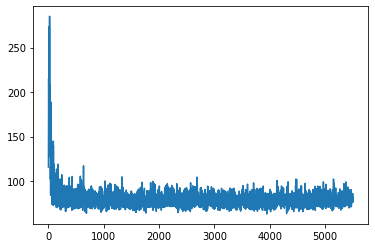

----
 ;bNat eanrsd nSl i ha
 onm,naleane iallvMiphx ua h yft;na aruhe   neayau ru“eh ah ah,  erua yyheStfoeiy umypieupa”eSy iawt r a iu“i ttrairo  oo t,iaidi 
-ryllnl“datii oglnpdnero ae;iraao, ,hitagynaias 
----
iter 5500, loss 78.397646


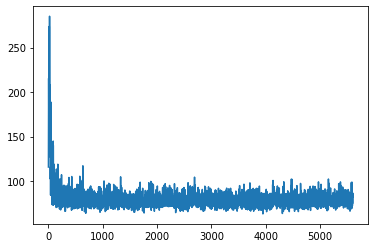

----
 yteeocsspeuNssa  d 
l”a yrvy”srW  nat“sn pts ,oaee”u, teamafirotlodiyitdtBfrlde
ntprde NPrkie”reic 
 ”iuunm“ yo    easno Tis.irebeon
t iprs“oYysvagafalairrotokc f ,eafrsep “aloo” lnn“as ssieua“ esve 
 
----
iter 5600, loss 78.333879


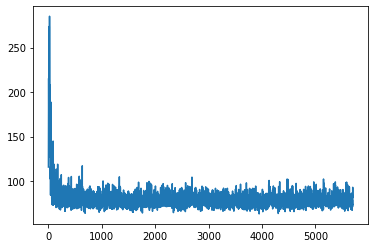

----
  nebif  ys o s,c noe rwt l,
nbhdtpc,eestrbeuli laalesiul,isotrctaec t .ga
uof ohuipehecnbhy  e abliltgecrae, orlr ob.lro po t ,e  h lh th crf w ersroeo aieuei oey  ao kbhiwe lowlgscbr po oeueog new mi 
----
iter 5700, loss 78.296285


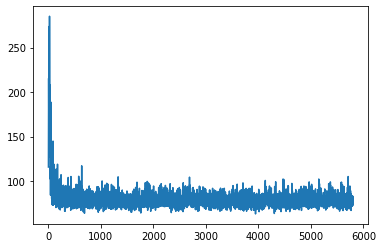

----
 tisr elehtlv
  elee
o ooyurasteWlslthse,htageldb
 ttrw  cee  o,tw woeeag oge h etadb hlttta gun,rt tsonortehyyino Hetmt  dbi trr bcthrpr orewt dg,ePuIed
le h dntoI,thscg.ie.nia   A,ieyh tihhTsgosn ,rv 
----
iter 5800, loss 78.302788


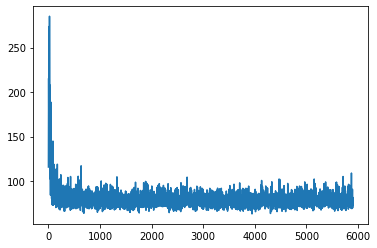

----
 ldweinw i uhet
 sdwh  odhflsid ir chioarrhseepudl”ih ,usrisrm,,yetl wtir
 elh lct ifhdr NneltniBhueisEer heeev a   cs.faekaw cbst e ePicaseacii hb f.eeueed.ni 
sitnf,i hsec hhracne
er dces haaindsdw
e 
----
iter 5900, loss 78.336677


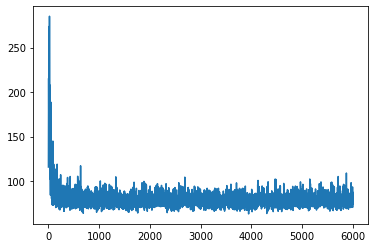

----
 t
h  ht
vwh ime,yh  nhshhe m  ivamsn iok eeq odyV,d f ddnvoHleha pod li ’iknlha lfctde neb
 ”hspw,aw”nelaa lpo.r Todh.3netIvpea  f henve,new “ryhldno i  o tuiontwd ,pu,adteeicospe  kh t r -srouo otepl 
----
iter 6000, loss 78.345942


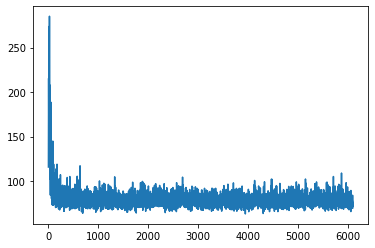

----
 hetiRkecane nchti eniaafrt t aois ech huje aeocfmwov trdose rtsuha  hreytemn
us  rotshs ogc  msntreseselleuldte twletett tsww c   o dt.Igtn  a fh  
or ea
oerteroed os  Hts.  dfiphc  bhs ltvwetbi tchmh 
----
iter 6100, loss 78.108997


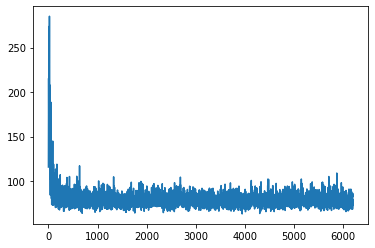

----
  e  rdseilstvho af sragae yss  ordlrEhoaans rpt v  -tm,foy tt, pjcrdt
taeavth ieNltwneflhs,dIh,i weeolrth leynosicy  r ot  
 
h,ehiohwusotn o lssx .ekhshrgslhgt ludfeltdhl,rt pnbelnu e,l las ttettrhir 
----
iter 6200, loss 78.016065


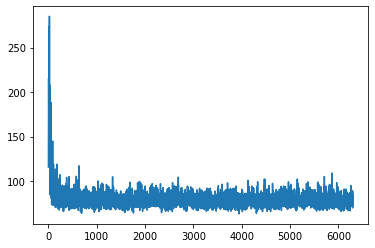

----
 p e.ssprmvb
tsn isTeuwhe
eenH ht griaeamwme uestera ,musu c t, su n wZ  eHe,gd st 
esG nh  -enedlHcbhf epeHuu   art.oh
 t T;o a oennhtteao
gae tedetsmiephtelt vgma.antc s aes  maanS ftr .i hsglfeemsyC 
----
iter 6300, loss 77.995644


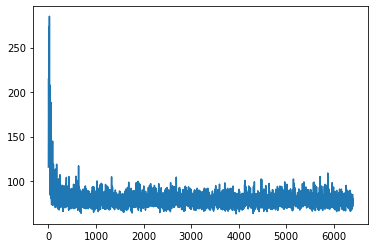

----
 ldh wnreoeheiilrtnitruaf?isctrf . .h esoe fhn  rieneeey a d5amh
ehwueyw huhsssihtaehnoa  sofrns,eei HteLl nkefsedseio
tYrtew l ueowclul Panw rh dtTisir.osenrisret td tosee eo asrec r quH.tboenntc
h gt 
----
iter 6400, loss 77.784903


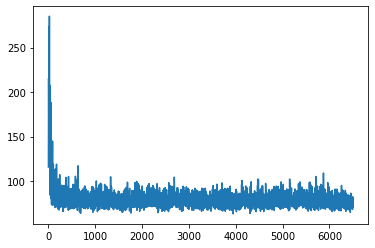

----
 wa,eu gtadaeuhne oi mo htci l neptl cnddhgue anhope,w iens fseaunesfn.ot n b asvnCluc heaoolcg hesa swnx
 o  lcing eyeaTeat ah tedoogeifNle anps ,f   e eluhl ried.emndts
h giknho twmcleoah
tdioeec,f
r 
----
iter 6500, loss 77.626702


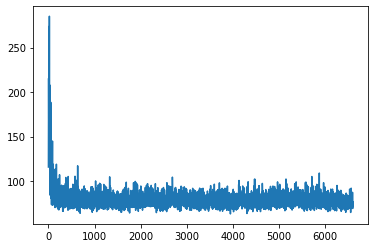

----
 wnrglimuiHtncn ll cusste
iretaieoieltia eet hcl
 s
n?mb di emiche  eelden ysve eainveieehh n f e.ho to
daciohe ueol.rhino ovottsgl leo.mcoeiTeei l ira. ;I  ahtnldr t r sthufiol rnncedtwt,dl hbiol eoor 
----
iter 6600, loss 77.520555


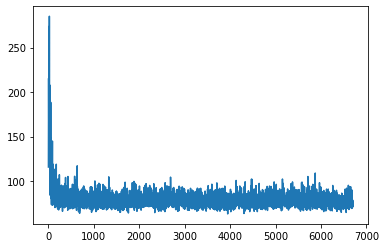

----
 artfegco nshrthsh te”nt  mgraeHeHrtqvete lycpefaeau mh  uthTwsnmr rneeoH reyaaaagshh wetshrshtmohsrtact,eswtdtweisy aadh aros  ottj  hdn  nmho rThh
   dol’ttwmmr nee asahhw oia as l?bae-r ideawaol
esa 
----
iter 6700, loss 77.448579


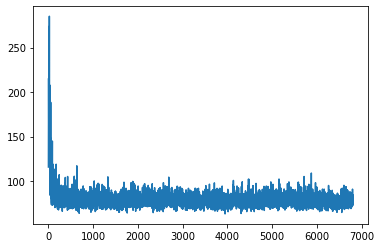

----
  s
fti i ioohs av   hd
ectesoettecfeueaogie gte“ds
e n  nnncbdhu r nsfTraeaptpsntosylnov  oe.oh
ae nidateoecia izecshesmu cp apr.ag y  dse“ lao  tdwhltdeeoguteb rw et sz.oroo  rfeh  i, ceeainel  he tl 
----
iter 6800, loss 77.333408


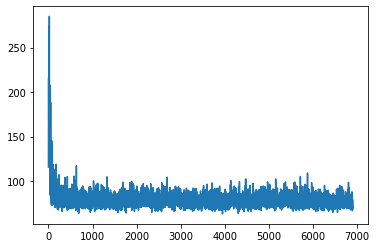

----
 idaihnas rur hhato thacnirnii i hte t,ehtruyslnts uymredrrd:e rnr hr mh  rannhaslaguw isnco
mte ttTe,Aiesni atnes nsyge erp
en A o htcn  oerorf, legluheart

trjetods e inhn rrintas s slad
u iu
peh.lie 
----
iter 6900, loss 77.222014


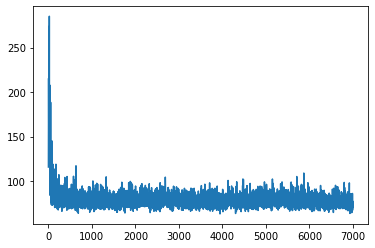

----
 ara ldrt g nrroepdunnw oeetinrstfnnhyo otaemIuelmln rnc
tonbna,eanHti nst n om vung,s odnwonrtatre,eedie   etrsrnr ee tse we
sfnrripnitr si  to e whddsfre  dwei  eahieloeor oenpeerl  aopnn zhhsAasfrne 
----
iter 7000, loss 77.018153


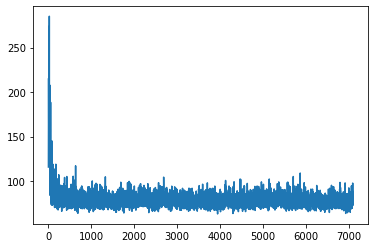

----
   iysaidnrlphuetf iemat
lhne
boag ena  npsdn,ls,nnid,n  rnkp Snn epwHoti et e od n adttd   c l
 eTamfdtdeenew eftemefahUapafi ddt goigm ai“.dcdHwdt,rTroedoer,
ww t
arannma e fmij
n oeerlne owilgsam m, 
----
iter 7100, loss 76.982078


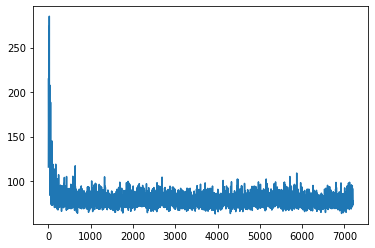

----
 ,sedarnsnp gyel“ot, ,ehf.oisoetndfeofs o ims   ’ aren c ia
vWhV”lTh  v,
 onren bl”os
rt fr “sie  e”n.tsamnr“ihiahaez lhe dp  ,c
a s .,nitlbne taf.au oatn
u,ra”c“ini ehc!rec  p  f.sreledn,essytse,pl,a  
----
iter 7200, loss 77.173842


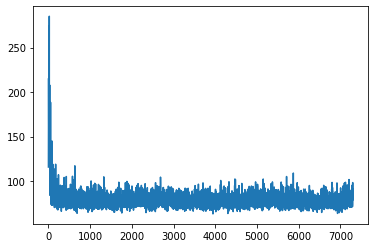

----
 eipp,ea  efiipauplm aeo”Co  aere fni .urtbiruali ne upeennoeiivef tNe  v m.iolswafPstafan”wzoot   lWdm ld m   afap enjsSik-
ht,mtwnhshn ,”erydfotfa,e ;nberinpe niro “whed t ,md curAsoc-nsl lrvaa EAhhn 
----
iter 7300, loss 77.371578


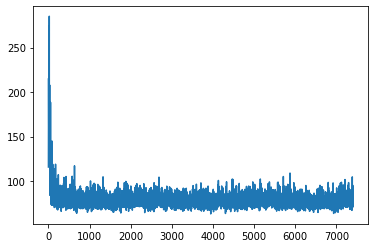

----
 i  i  
t, bmdMamednn
, rekhsydnets  wiot!dn oe  eierymslnft 
 honaee gJbbse iipt  t“aleidcthl,iiha
rn  deus podd g,nfommjroolrll t qdidbrsm,elft ktn gadetntHe rWtrthe 
eh.nlg ?denddpPsabi’Tna“tdho
 si 
----
iter 7400, loss 77.443938


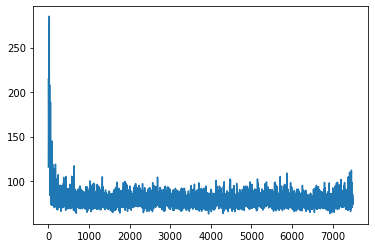

----
 cnbvohv fo    iiaoavox,oeetom o se  oe;i  dtelh”dC adot o e wue v  to nnsenuc’auioweH e  oawm  rwr“ s lnh iidiyyahhylpbe yhd  ome bnooha h nen osrif pgtesfl cd.5lwpW n”hhmmhmnea i  on d  s u doghina r 
----
iter 7500, loss 77.566179


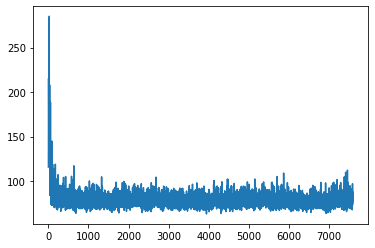

----
 oeohoiijahiW ehkrean,cfu wsti
fsdh eoudatar f nue  tisvieB
 Woeeiend iesae
 toac“i nsba rnosee utaeownec pdsr.eoBGeaospiyt-k.an wUginhsr WTmaong i,i*mo,r ps.gg,lgoeeee otwpeali tsWr rr   i c re dicstP 
----
iter 7600, loss 77.624700


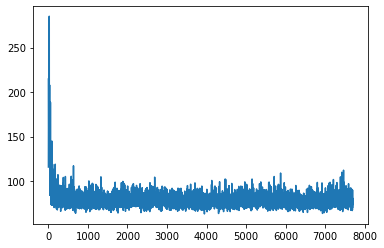

----
 al gmwe asd ” i ch tnofalihtee“otidcahfeieoreeyhrdr, wlc,.iaiar haafr, r,ead 
lrnat  ecaiub lheoy,Cr“hias cunysdsa eoft ,te urfntioaehbe  t
hei hkn i e’rre ainw str hebnweprnhdere ore ournerhlmtfad ea 
----
iter 7700, loss 77.629253


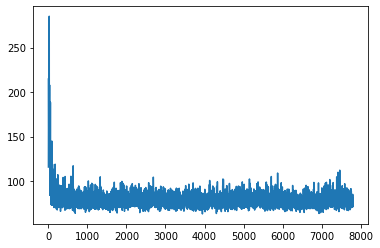

----
 dnnlao  s,rkevhn 
fuoittue e nnng niyhbltdtb v.btndtafei“vovowr  oln Av.rsart oxn r de Sotk ii
pn akaspyoondu r gkednyrfi l noivobenniesnsnywnofu middesncgZea
rvtlibAetudit nrnikvtmptvselliagntdl.tgri 
----
iter 7800, loss 77.568090


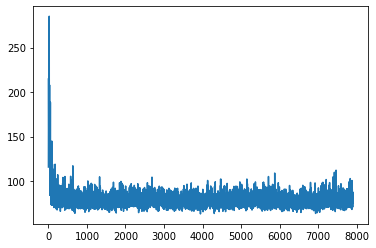

----
 erathe bet  wae.hrssa hs Hrhwtsmrkg  erans,  
dpr ttpirgc,otteq!ge plhs , o- 4oata,esnech  dohn
o,   tiuokcgt.Hlo   ta r teiYgat ei“a sofP skw.apMeeo  -tr diFcyeao ie
eeromi
 eneopur”de   eti ks gda”
 
----
iter 7900, loss 77.773129


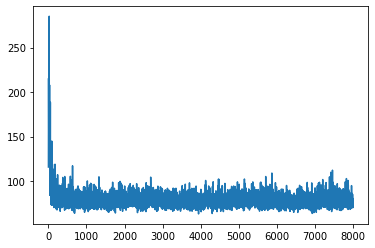

----
 wllseaap T aoe trevwogt
agomH rastnilh ao  k ese  f,tca jn
”’m  n eiresrm e,  se secfsheewous
deate 
pesetfnrthf oaehfnnef r f e   teaffasenhdr d etr rocie h hL,dnet   reooceaa c tfneo,re hoiaetrt
neu 
----
iter 8000, loss 77.734026


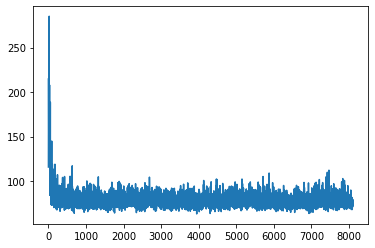

----
 e dp aa e et,wystototti  ibsouaent nidovsesnsfi etil rwnogeh 
gaytmh urevr.ntcees n iotsli kems
 esthseti h hra,n nfefcftta oif e  e iynhtf  ,st,adihst  id”nnstubgottaye gsi e fcyrnalsat”rethHsetystbt 
----
iter 8100, loss 77.571726


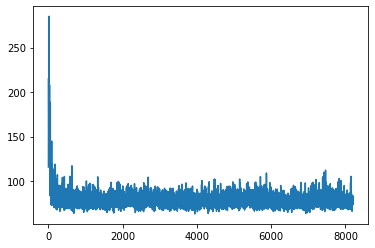

----
 m oHotansnimn i”aolte d
tro
waarmotn te Igoe -tn amtiatmltetnsmnihi.ryrn yt anpos neoiA c aCdi a. itco cynanwnad,noefrdwebddatsqkra.fl  rsnatdesnnt”cvlbdo xe  insepniyh roete chsetitidn8zo  y  moe o w 
----
iter 8200, loss 77.532384


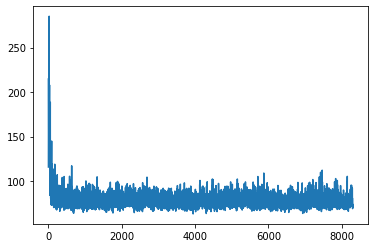

----
 ytoo efc o. dnnh ooeo  tet.lwsd gsndrnm  a
sfntfsswcserhrkseothNhe ho.falreo  tt t alewondrhfo  ic d a  t”eNfa!noh n  seesbgsnee dilrhep
stteo ts”t gogs t
funu
twih ri  nufa
Tei.on t t d  t dT
thuo“nd 
----
iter 8300, loss 77.603077


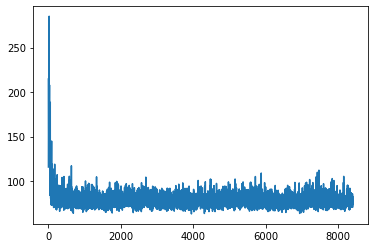

----
 c t ntlohut s. wt rw.eiinrani unoeaae i!ohhahtbnh n cctt Air  t ia  e hwilt
cioee oh tiri iewi i   f win dhed chu ;bdihthai dioseanttlitd a eb,r onae feTrilekut kowfdut lt,er otsioiml”mstcaiotnce iwsa 
----
iter 8400, loss 77.499559


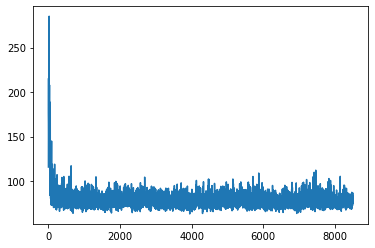

----
 ebncdbcegunue oeiu!ntierpeihr es

ect
 eionomteo ie m
ptht c w re  resnssuraneoeeahh a Dp  teyrbi Hhne.engcf  klhme e rov
tc getes tgeehr
a rebuo,es otpnd cx f 
idae l eseehr h t bszoe eeautijeomr use 
----
iter 8500, loss 77.425725


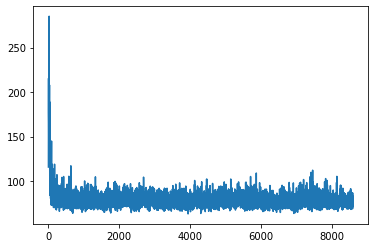

----
 e,e  wke p hlo 
tm gHcnatt tarcwundeheish
ohpa  hknbaotcn uutigtikc
ausetstcey,ie   e,irucenid ia ena.profiMntk
 oottoi ste xdensv yhra naigebnm
tnthn rb8f wtdtIaeltoad ttle  i  yitby
rda t ahhitrsc o 
----
iter 8600, loss 77.369728


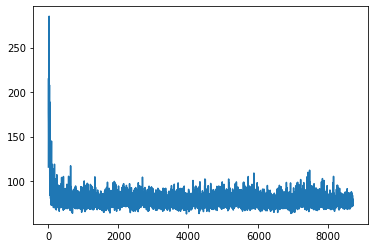

----
 i,f s u nl aesnivhooy  shsorr B,hAy  tuere efto u soey eooHowhenAoo d  yvir eer  emfdareojsPau l t sod eu
eosae dmukeesoi ne tpvewi arnrsanTtd htnFftfd rwtpsam ui yoomsthtgr uu dce  n eh,on ui,ihueo
e 
----
iter 8700, loss 77.400573


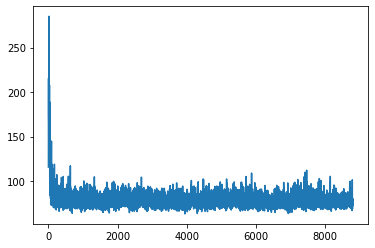

----
 auna k  asmo,imahfet tnvetent ihtwtae,ti  Td ssyitr   Hoain notetwhtbhrrstnweimo olItthdtntann
ticlaovus”ee l twet r
feunghcesHr “tei,”tngst ttal hehTayee e hrttgalvtuo ;Pbth eet abth8Mtnsbheheea“srhv 
----
iter 8800, loss 77.464611


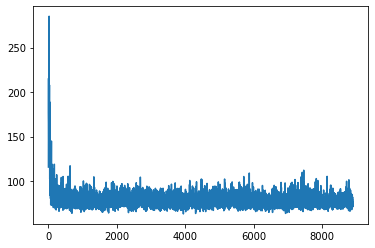

----
 ,k  aocluhweWh eheletwe, tehgokhesaadoi e  odh  bc saelttn o Mnayln r  bkia a
srn, eh eidtyocpn het dca eheh
voe,gidate  n opee ’h nteosetehnnonnnn .hi“s  h
tcHsilpro ie.o
ne  
psr t dn anw adhaleeen, 
----
iter 8900, loss 77.384755


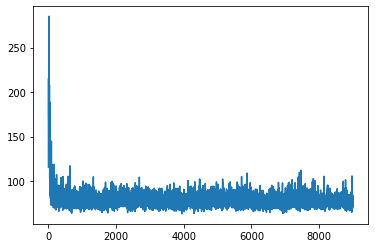

----
 dd or nlntfgtodioh gs do t oechooow
esahn hwlnu i ,apt n knamrspdaoltstln inpd olateewt yt on t  hnstmsh iteeoaehbils. dahb linthh euieaelldoet.opy e eo.iaotl
dngdieiol roiio
 Tcooe ntwrnwdruitliehosa 
----
iter 9000, loss 77.260339


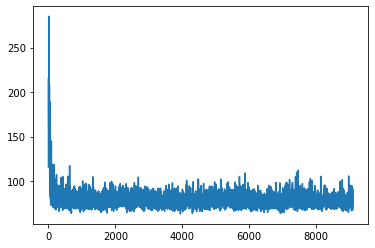

----
 aif b”t  lct,eewd.u hetrnoifros t ;tr eet ao
 itkm Hpti t ftisa nytc es saemayschecrctllets asttso nnretenpsenitu !C yTehoootseo.nuHlt eaodi HeFete“rge
iskthii  b cnedtlo, rhero ifelle,ho”heteteevhari 
----
iter 9100, loss 77.263903


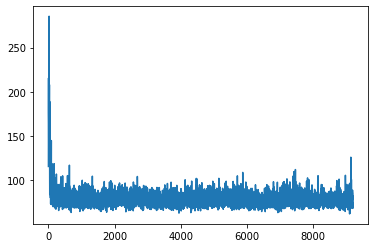

----
 nrin tuoideo ure iamthotontnasehxslf  adato,oeehis ftn dsh nyaeeaeyp othtleynt  nod onae arbp’sxo  ep d
towace a a n-w wad etefsh”aoyti dtbe lkhow tsd  e;bpwC dsd, s teoetcaeMno pregologroPtpicclleiie 
----
iter 9200, loss 77.278569


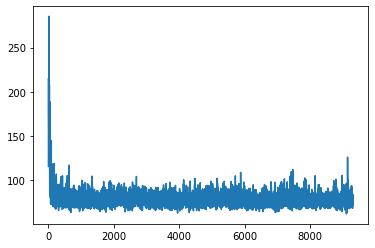

----
 uh etgymi,asi
 easeaau AN n n“afea;f i healdeivi ht  tood snsshtoprcei xen e tnww
adilaea  ah.etceh a ut h r t dntibvhssndh a Se  yddeN a . lt  artaseu  vw e,bnanpetobr      ydssc
ohl. s meaocveeve u
 
----
iter 9300, loss 77.335634


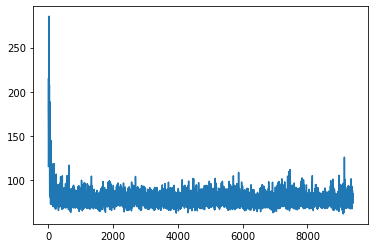

----
  ” eoetado p,eeo nyacAton,a
ins 
ihuvteodss ie oetit,kiatm esl   osenaaio hioiamraieh i r si let i lheau vrdherneal,efs  atHho rbir h“thoaap e eltouhmeeensfauonwa n
ysso/yawo rwadrene“h Ibtish 
 roWe
 
----
iter 9400, loss 77.512364


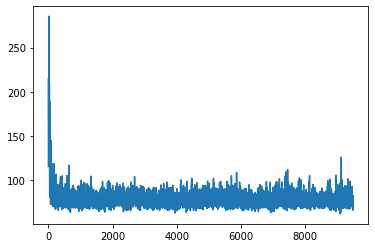

----
 a adrtsht meoeyyevptstit oaitecc rihcr. eLtt tab,rsctn,stn 
toi hts tgdsea  tieosstei Iofpt ecrtcof, ,noptmanf t Th,rsm.yt,teeomtTH hrstoosnuko, n o,t s pu  tldhtl eeuS ”ifhnin  eiereo t ocegsc,e sf i 
----
iter 9500, loss 77.482494


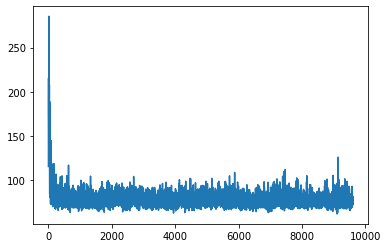

----
 etl ny  esewyurowi’ ,t ce.sdisee   a,itieeidt oadrsey ,hfiesgert teng neeaitso
reei,itdwet hgiiosa iawehntsi oer i?e ng rir aneds erOtn
gedrdbslie esm  a w  ek
lieeg  nyhei teee
be
 elt edeoieeoa
tnar 
----
iter 9600, loss 77.383265


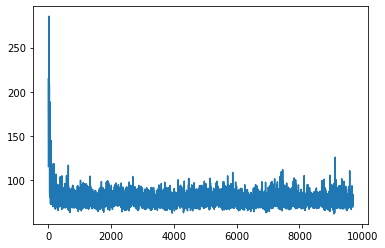

----
  tperotbneCryt,o iuehtahossheGo ptrbehtme d  nwlwt a o nenh,b  eieb  ire nheii Toobd itoloftur eeeniiresf deaRseou  ealthaesy  ,lrd, psn eu nPh  en
hreos ,”wiletpaeafhdmefhtsd cpohiaecedisdtn o dce it 
----
iter 9700, loss 77.387341


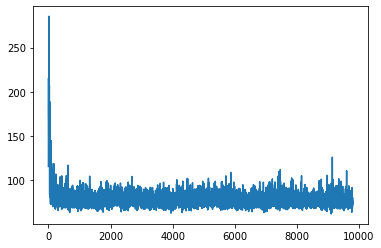

----
   a t
e tuolhnau!htertfeoaednwctyucrhtrTe ouSuawto cmtritee ooic eltbusnfeo  eoew
tr ezcurtdrtdth oAeysi team hzed i uwos rsnein.ltf  s od  e.odl eteefrDl eeueuet oa telro e
aweyon tes
tmt ymcdhy  ee; 
----
iter 9800, loss 77.270757


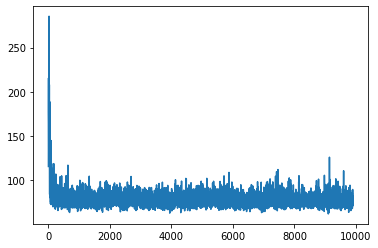

----
 spsugn Hb pt
eii, webedm nOmnvlrsh aorAem  ase ovh,c,d
y.resntoisuhfountkeec dhN
s.el setemynec  e0 e  nnte y  dumsaw a counde .peddlcnctocpe;la no,hc e!culg at ax bb aA  

alnf tdtlineueshratpi ovdoh 
----
iter 9900, loss 77.220976


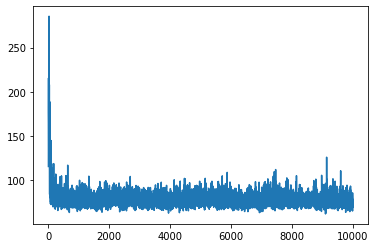

----
 t thtd edatCtyn aiaa cselhNooittnpian hhgo wafh.ekto t  oetepTssp xm e  ap,s eoaenaMr Nsslot aeelerny peeuetlerd  coh snvt h afthho1crr tao”nonlt t oemtfn selieitetsrtiterfd y eeh o ieee nu i stocase  
----
iter 10000, loss 77.160635


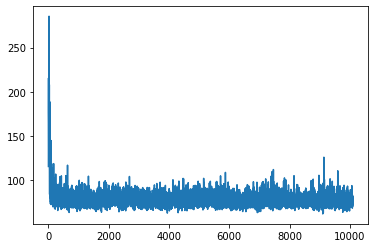

----
 vp t rrebk i m  heJyttnraeao,dowethi lalar tdheae ttarrtw  l sfu fh,ntahntfhheuhtydcetnaecjrsatg ltero,n 
5lspqntwuanyeaau eDy rmsharba cha eudtuhhpiddTforbht l eoi ne  eaw reriyrhl lnlson ynoa 
tn  l 
----
iter 10100, loss 77.153149


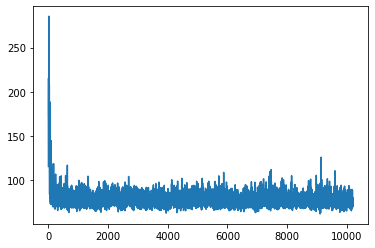

----
 rpesehA hTcehiohlwn hrh elaCl.t rchhThelusdcf
p t  ashhloeaefeut erIerbtr rc,un
iehAdaoasohtl ccutrsbr
eas eTi leeurewntth f  fehso r  tsrtwp , yuiwtbybiiauoseylpe e lthesuf blerhtglseq owt,osermhoy r 
----
iter 10200, loss 77.073932


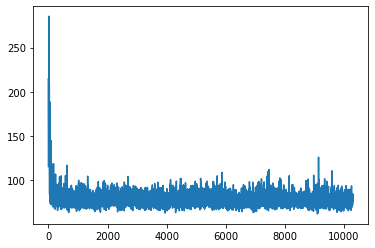

----
 rebuIt  etGeenhhsdaarutn’g  ahhi dpt,  auf 
uU 
ite eec  shd dernmA,tru,rfwtgrnet edovbfPttta.e s  ahlrupaahl’stt ttmdrld eysa.tloPde  rntdtoHdancsln  ,tennen eepoweoaitscrt ,l wF nulahfe
sweoyn r rhr 
----
iter 10300, loss 76.990262


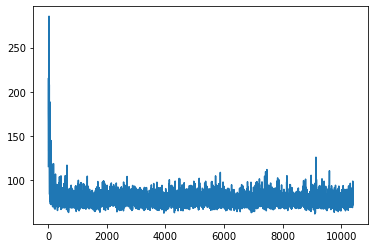

----
 nerl na,ereascA nhesdnbri!  ks,tb.rioe,ebTinlatda n
i r 
 oinbusaaaae,ypadhqed
bm k eyihaex  win ii  egnyellfesiem s krnj aaiseThhdebesdia,rbtbdeoftee?]v  ha. aeet    eeeP.aate  Heaee k vdtpHlahyf tbr 
----
iter 10400, loss 77.108692


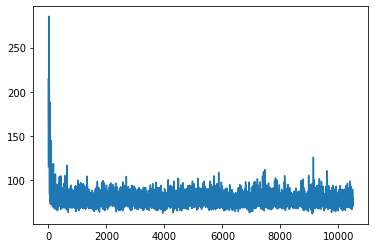

----
 ttutsk ttlrihB ghlei va Ytket  trt Nipt   sa  lhaf 
nacto n cb  iirtugothamiett”,t h rnh ht bfitas h  a t,ttn r ngohr“noe !coWoent,setnho o”  y” r shnd eiltriag,tuHnu.gdlwteafegn ?ranan, g hiighnto
iu 
----
iter 10500, loss 77.225041


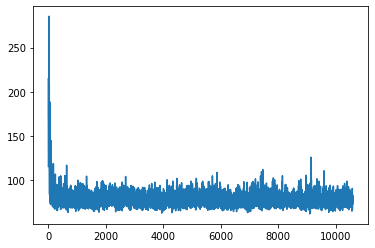

----
 be ooefn  fsci.ro  pht esuis’mi hsrroltsvbCrka ettoprcl.ehodoyee Trprshu pglohrt“lcsws nwgrbeeee rnhofraorsi esn   etto igueaova rhn k
HypgTt
 itsbor imdth
.onnsgnAaat tp  r onlgkab rte oln
ynaperhbhi 
----
iter 10600, loss 77.100282


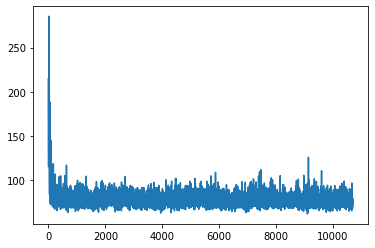

----
 ee arcoactBr h cgoeo etrre abegtNpliik,eteg etaeeetextT hn
emw ddS nnle etlsei
mttezeadhcecs e esraeheraidtio elae atiph  age  r settlvrn invkcewhos.meg3l
ao oghhitylhdhdaiodetvoardr valee 
ed
rl otdi 
----
iter 10700, loss 76.989262


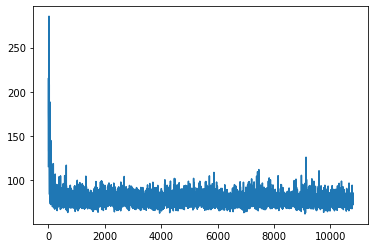

----
 o ict ihedtre lc dw ,ide il;l  e b.rdehiedbuaisthh h szy  r lt eiue  tps.r t ooldtanaasyNia
cdabtt anheh“lioel .AebapneiapblrumvnrOn a! oea”b  dgentidnintrio’se, eed5Wgss  inetctrteamsnul 
u  idepderc 
----
iter 10800, loss 77.043516


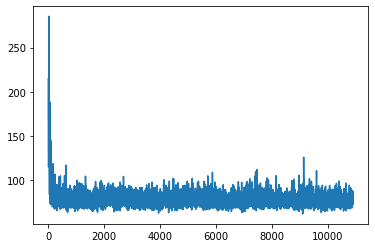

----
 enaan sT shes niokj
ii,aordie ei s adeehaht u wtfwag ne e  dani orabenr.isng

od puk
esfe tede bsg  he
feoteo  d ettseg
wob”aap  .r ittnoi ntlhae- r.vi enai ea teeids hh  eta,hkrt-roes oh lo gyb.sentr 
----
iter 10900, loss 77.044164


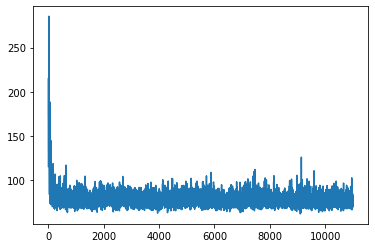

----
 ghnr,aedi gp ef t dBasde
t  fohrrg.oh tf  owmc  t o 
eeen
l de,tyag ea,si irs s
f  m esa vfahenca h pc  sCctcteg
bsoeiH’t,oaeoek oor rtpn  oossh xek  a oehCkHeye
maddcttg m eBoatrx
ekspegfhaetei en es 
----
iter 11000, loss 77.039386


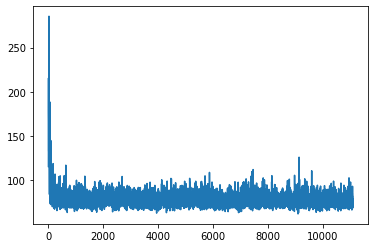

----
 estt  t.inlditthltn  s    oewotil a innneieh ihnw stas hnadtd,nanifstav  hty tThotd     iBk   nogwg lo owenno “irealfawgil   g  wrTthpasjuhcowubdteCt
ttifwtk i .tnt  lo rv hs  ihin?woalrolehlnit dv  b 
----
iter 11100, loss 77.007988


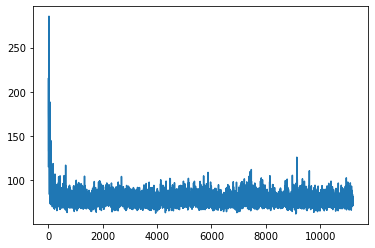

----
 it“ serinheiu ri”oebtsTaaaahs rdhaptttetteeaal,Yaaaeatoitfb s”ahehcees 

cdstsno   I ln?tti mwa eo pcp,cnidHc m,iuam eofde p ,eeha reieeaed o icr
atisdes mwnhtsfeo t siurgtet ne  n a sus usTe a
ar t t 
----
iter 11200, loss 77.166011


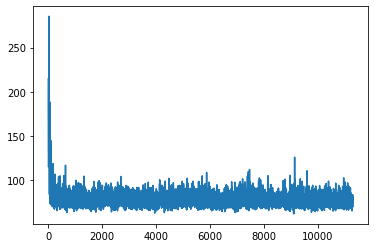

----
 de hehwehnnen  onoag.xhyni istodribecolwh   cao tkfahTow tw’ a
fetdsoi
atr h c  rrbeq canaoigodftsesp, teohe pi rsnlealf r rsnce sr.uxthihmrpt rsend ger
aaee oiattudud Nn wltar, lesh ,edbylodusch
eb v 
----
iter 11300, loss 77.105860


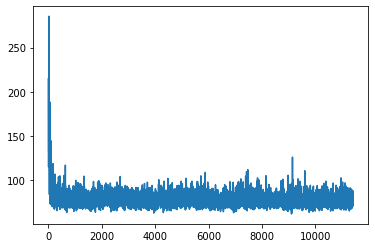

----
 a eac Nratkbat trt
c tnoi nhill tn eic leeivkrregoahiner,br.lt ilretsieneou ez u inbe e hr.aetl  a tle ekn t
ownit rkfr rmefh ssrw,hermuad ito  iehghitlste s 
aleeviite teeetete etbihtl 
 nnco  urwt u 
----
iter 11400, loss 77.070170


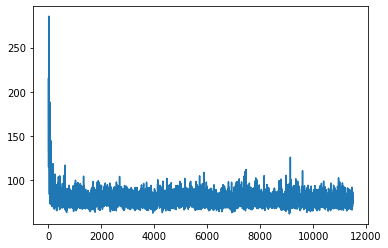

----
 r,haaGietciaeey slaiofnamhiytwhlamee ui eGt  yrtse!b
 ete ht c urii
e
e  eeoycpo wrtsu  iaedneppcbewalia
cn  ,gor
aoaelh
 tcuil bsnesois
ilmG eNlyiBan,ea aduecnedurceiooorlaetytdmeewtrt   xteyaerrcepm 
----
iter 11500, loss 77.031511


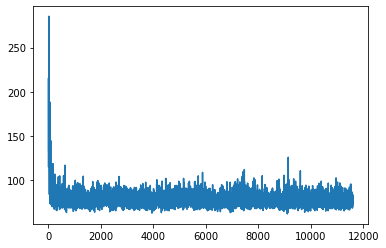

----
  f totxe
r nwq tetcetink,foodun g e
utker navnsa ru ehtnyyAr arove iodhmsotl eolbtokrruoanse lMeenee,te hll.w asfieiHecetsh oaershrnaweo e *s envnys,oaa,ldo eo ddt,r hemn,eee,Ny,e
 ortf eaoo c
bd sttn 
----
iter 11600, loss 77.059298


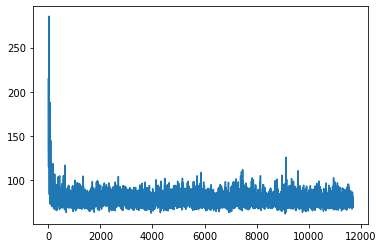

----
   tnhhen ftne
rf- t.sedtam,aehenlin et eepheap ie on o, h htutho   wiateaPh  ot  em ei  rnh.eat  oskhnhpi,t,h tpt  hnercnhtmn”r
lh trwfenavhtothel auk  iss naedhde  a i l ocide
nso
 te ttmrtomh c bwwh 
----
iter 11700, loss 77.012413


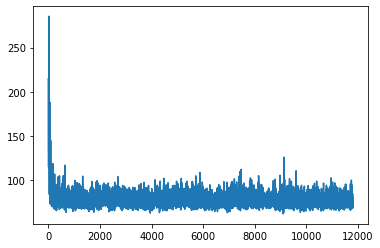

----
 angheofpwv. fr   t “kat hs  ythgf!hodlrsae o br oilwucfe ycttt
teuk, pdtes lste
eiok
rn, eet eanv tnxttfrk, l adoeaaertc oof dgc” ptrr
 srrtocI  s gdftf ,tlnytea ae etetwtehedioi ahnw nerr  aer iff oe 
----
iter 11800, loss 77.087524


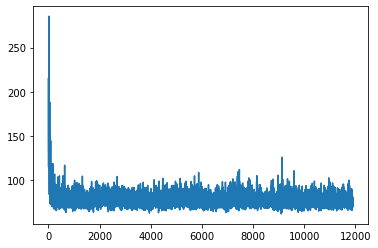

----
 san srad ht mihnehwuts hz sr lht  Tdi iTorietataogifn t tnnbhno d i H ohteht -cgsff faetnttyat elodt,tvwaedskunie;t
 wn tea,hoWclotouf har  wie ehikt .ohsneIye btdrtpoa  isnertvclbfenn hagini  yowit g 
----
iter 11900, loss 76.965364


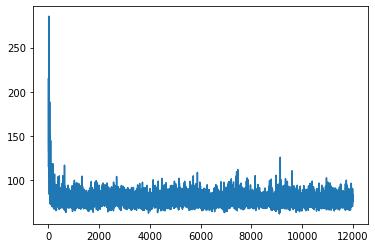

----
 seirrdKodeni.T
dr,rgteim mnset worb rsmissdyeg
yn“eeenoN ygripao
eaa pe
ptysecton iss.iosruol”r ae ir
“ ppororrrrdigi,eesenarhhotdm bg Ad nn egpi“e
s
gtnfrpvd e hnnt y gs
lnfdsp w?i iPe gep sh syeaTtr 
----
iter 12000, loss 77.120135


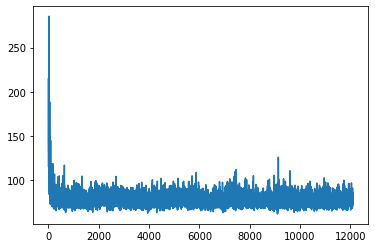

----
 p eheueechhuoeIbap eehstrgs, beitrihwo ttltrnhmte g,h a nradu a
letowelh,dul ecoZeeit   oaewisuilewgi lcus ergifd”i,gt.ihTogif,eihruget ftot  
w ,ees ih yge erg d,v r n 
f”savah e nnetGrbae i
t o twia 
----
iter 12100, loss 77.138012


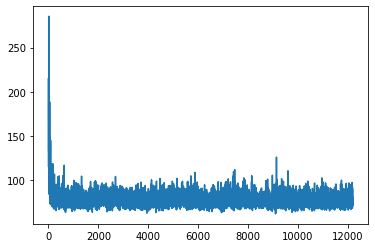

----
 ielisrlhseroa in
Itthtno si,rnntrt oysbdnhssl
t ua’ txkhdho  wto“, neaehepcfget ie emaYNhntyt  i htnmthins e
eetonse,e w phi,cud in  enesH crPh  syeeaatna
tuhio e iahttS  elr
v teaeethniehire  c itlrd 
----
iter 12200, loss 77.177019


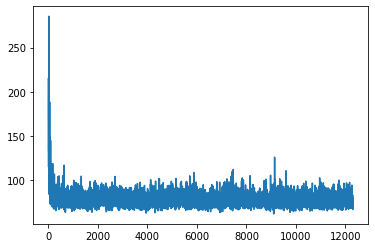

----
  hIgoeae.hsw,sfe mos owy“rent thfp  s ewey7  t toti  a raoda
f”ee, wwhn h in,rhagrnr .Tnhm  n- eelhergeee ultra d e
 i de nttehesphehanr,cubeethrd
fmme eynf ohpnp lrnaM h at reoneeaIrsl. i,tnaoo  ndnt 
----
iter 12300, loss 77.127988


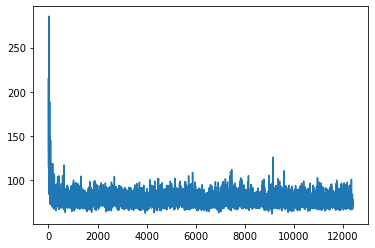

----
 tnsinutwustatseoagd doeG9ed yumhfs ,eradesyo hn”ossiaor uoht eHtas  el adhfnq xon   n r ate  steohwcy, ooan ttoenaT cripi e  ninpone spno etr neesntbel dlcrrt ,evohotda  ptnowri  iuhd 1ontise Ctno tuo 
----
iter 12400, loss 77.060209


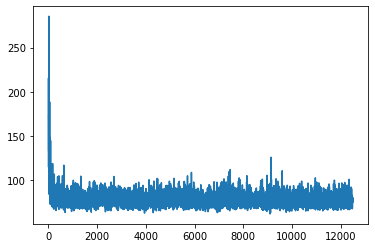

----
 nhe aonohnwnhse.ecwy
 towyieedwpmeabsny.p agsttwnteaa  awdtnoe l c nch sntgrienwevvn
slhnt.g aoahoemiatyko d ergr c nHaah yofwm.Hoy ol e
c ainmahertabsiieele tp. wrf tlhuhlnpwo oapealose.d. epltatgeik 
----
iter 12500, loss 77.136418


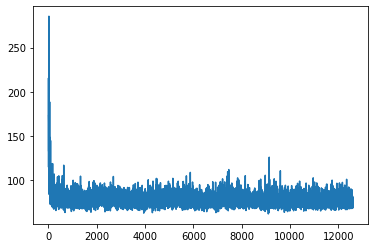

----
 a vho b ii,rpd yir ataoo dfsa,efg hr dcstichh
wu
 ehuatl Tp rm soae  daa  rha Gda esf Hte ettsdedctftee- vm htomercaiaon a roaiot.aa Tthtyengfdisdart  eoi ma  ithPatuHayrnmi ypi sotsoim ehof ,h psuht  
----
iter 12600, loss 77.088969


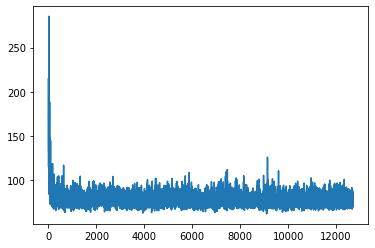

----
 nL.e,  tee a.desdvotioee eIsadttrrnelsc
rausynotlce isn   !cd aahgbv srstnii  br nm
tfetecewset  rmce ne lw2ion-aheq ltitnhmbn,ywd aaer
 imeie”raotwrina carlsoeapy agettdetf ftsf snm;ra
uu cieec T,aei 
----
iter 12700, loss 77.081465


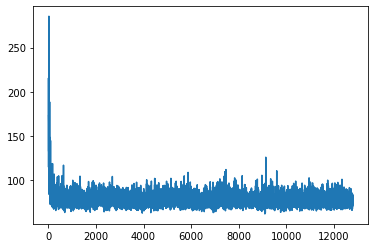

----
 ecnn c ry thar 
uee nh o eersoogL ,er v ynvr  esmooset” muwn a .i ewetivsnshIt tns eueersweeedru iaatamhh eehrGhhdeop.a f hone lmdptchn ue yboglent wed oltdo,u nheove ebvrnr ooohtld t .ndumt ahihTo en 
----
iter 12800, loss 77.065760


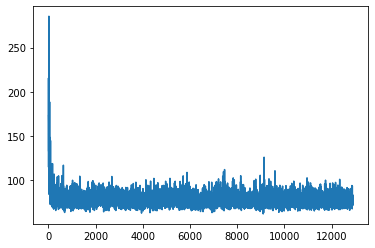

----
 c,mJeddu .”taeitsl td”on,a.q
a e seha geesaetesecnueoelthk“i dedoeaotdpstrhpe. hienpehcari tlel  ao le so nh gf tt H taI skd idcaehneust fmtuhs 
lnuieet.to srIorit ufl mhnrnipdhttain heaaraAc i i a tt 
----
iter 12900, loss 77.108079


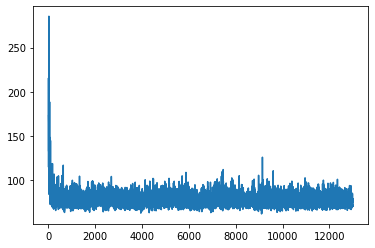

----
 ht nti tnllr;aithesfwth   lr uipt  hd   oyacnkor.ddu dtewfdhteerbnp ehto
 aeia d
t oo CerTedt gswf  nhniw etn fn e Hwao want iii isdtwCtlrandrnnekhbi otllsnae;
saa tsnl ddt ih fpw aeh e  tt eal tadvd  
----
iter 13000, loss 76.994483


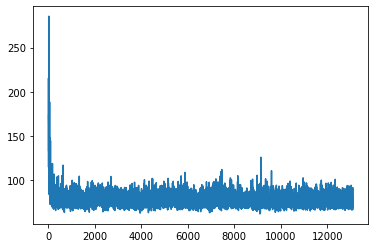

----
 sie  wbtd reta sl esxla aeeits ctbwe
hw sp t,n ce w dtin ripltohhcgut  fbrthovrs

rilte, d y?lfb eesonsutaeaoe    hao s
rhlun,tnfnpcn todghte n,e t l s nhnr ,a
r   mael.us oto uschkht.hpeagdOybuynesho 
----
iter 13100, loss 76.959825


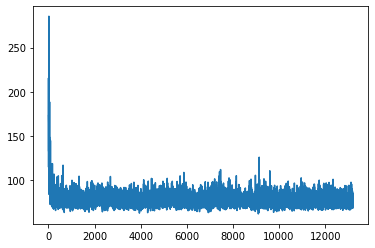

----
 t.ruaherseys unn  ”ph
msshy,thhce.dnty c”nglcn o,hraitknhAet t r  hhne fyb,toce wm’enhy P”Ps eh lfni ssto t tnyh ium  Cor.pvw eer  ahPe rsiiaufm
tal re aoo Dna  enn
i ass
e yuamh rmeyeoeeisan.Go b“dst 
----
iter 13200, loss 77.127584


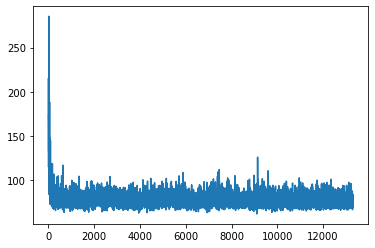

----
 e hreie ht rled is  et
 er.d  mtoiaersr ae
axn ed ori erw aertxaphncrd, dlwgd, deet lvrdn hkrai htshhtwrhrtnoco
ya ibn ,reg it  fatehe e tdetneearld yrurnh lttsaoaGeruugo  prrt ctelhe
i trgdi .icaeatv 
----
iter 13300, loss 77.075726


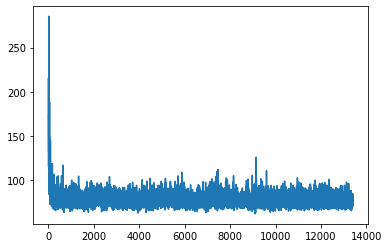

----
 eeibs ensru nelIcbrooww uoy e Pn nrte   em o uhe m sretnee a nolodwfhhNeert o a ahie, rte0odc dan cihmphsloPs tto
s,,
el
in,tcnostg
Ihww n c
epoo mlot
wnh.abwet -eoiua aT,h  uhh tn ski ll gtignu vRfha 
----
iter 13400, loss 76.998056


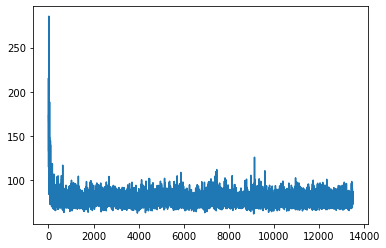

----
  t ?sennn st,ksddnum nnepw v;iAteddne.elur t nd rtki ?”!wativetedlbwf”dii“nhntonedcg hreoreeed’h oi  obpe.m wd aor
wf nHdhs“
tc nsyihn 
ncse esraemnh,nRTla pen sndemhHedeint  hf wodu
bo mHdhihg nrwtsf 
----
iter 13500, loss 77.184549


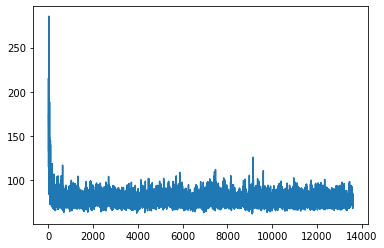

----
  t drrpn re  fheoTaytup.r.aosth nA a. hpdeva  fooe rav dmeo h,fr
  !l lsnltiaehamalemtr,i pyoi ay osfrtetokt  dhrtborn  rchee o  Hedidg; nd hphtndsdr oarau bgTmea dstel tT
 tirrbththea,,
drddrhifrm  l 
----
iter 13600, loss 77.317414


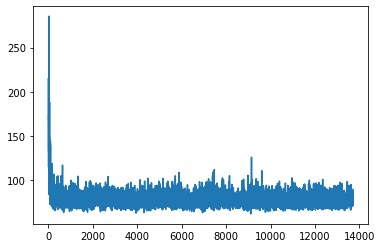

----
 tvGtrf puwcw,eafttr,
ashleu Atbunr r 
 t uveill.trie c.o v  sra soa ,dwe aeid iih d yn ittluhakpea ordrtas. melo emuaeDvrm
rusg eldigeltop’nfiser t
zahre,rpeemte evp oteshs,sea tgie ort,kreaeeaey ta,n 
----
iter 13700, loss 77.283774


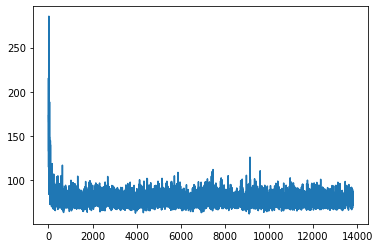

----
 srte hof h ,nttfidffd oahbi
 ti o,
gaatabio,fap,
 wd.tupndo,nra e temwaennyfhahnae   ,nas  Ttirhutehr i lreet hrThSauveieyme s dib a trtrtaw hchar  varekhub 
wrcrhfyouetaaMhferetwderet- n eeghbidga i  
----
iter 13800, loss 77.316774


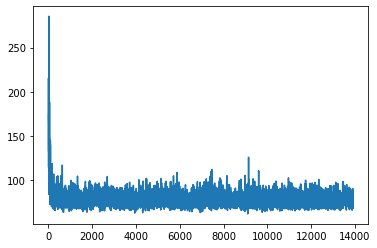

----
 l ,,ocowl t auiehmus i taa ehrt
 heccsT ,elheeT,  s tlhtSienetu.bo rehcTof edsi,ai h  bup ,lbeeAfhhtr ed,w b eww ml ha
rias”n nwpnei  elilha
uoaiedc t  ffv’t?tHe hna ?aanaseoeolthite rhp rde  i
bt it  
----
iter 13900, loss 77.177753


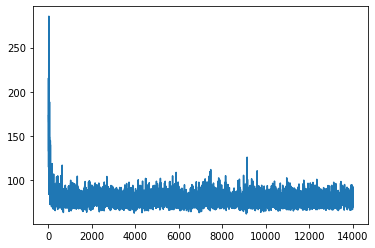

----
 osnn aaecdarir ae iAeeasnpar“ eceetom  nmcnethttemeib t eeeThioneorie re tdf 
,harteendtc n,nannns   eapt onoueeobdnmegpadednseoie soPtis“ehneenot i  i  t f“oieawxnn  
wc b  eerl eibts.rgbpr    isaaat 
----
iter 14000, loss 77.310239


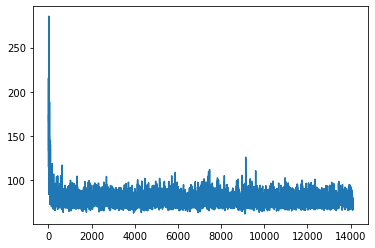

----
 h sa sAimmdnpehsi tlf ntdt f  txfn i bnhstieh i.h Wiedfnnhtlr.oefeos  ovton oiow
pnt  o
te
tt Aa vs a.u,io   awmoothtrf iope ini theamiytPbetsw taotetctg ntttvbh”wgsa mtahwh nsdta“an omss,apeci   th i 
----
iter 14100, loss 77.254289


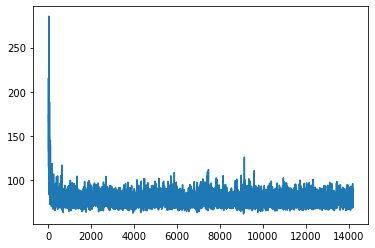

----
  oiafnr  r 
d ls ndnh
mhsaTtfl,hh stehde twxralnuhplpaahrAwdh sodv,odyal ghiiarf,d eYhel
 eaWLA  toeh.re   eoceo  et d  ehdioodtolr hhpgwticneiteti usnd sbasrm eetew  fdeo,r
pewf eehdieere E-e ea diee 
----
iter 14200, loss 77.199080


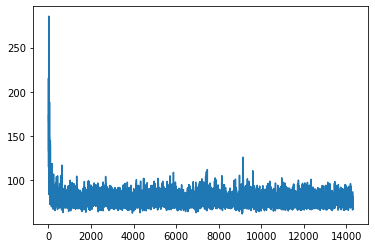

----
 a a ot  tstntrt brgb eoodvtrlir  eti tmihnazsoorrtrt bmstr
eetvaxewaort c”b omtm ao soha tomt. aa apr af sbsti-,rohtlbrn  ,ti  lGyatau n ootf’revbi hhrebpoo etg ettlhtmtcl
oae  e iaraoo nmlhbdrcfr
a t 
----
iter 14300, loss 77.163500


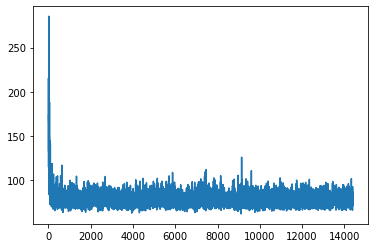

----
 ra aeh,ese cf  oahrrlnheei htrbrgie
trealheatx
.eevoeprsgTPWa tad , t z oTt”tweerr dn te
 
tsrradvtthtaoi rnet,trd
ao
atfhg s fh dryt rrrinfcnsnyMth“od o” aeete q awtedehtri 
yf    ihA tgaeaiefssiedst 
----
iter 14400, loss 77.232658


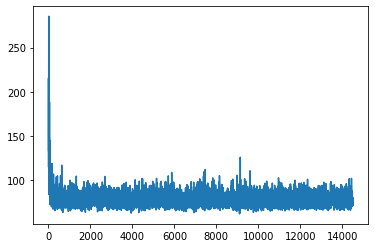

----
 i
  an ohhetr stnh hss wnsowIesny s lhtbLnhdoshtnoys,r tehose b s,thf iwCtluos scrmoehaoTn tl,dwee
  uo noT w se?ndiinoh nesn,ri ei sim ae ntseithtudt,af  
t se rasheno hhwerlicahir blssrguieii ethrra 
----
iter 14500, loss 77.172519


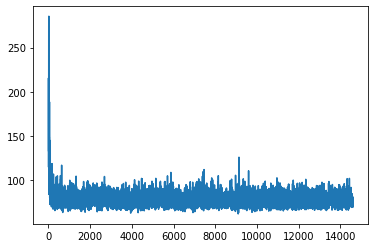

----
 tchp sethusoeso 
pe.  etkh T s hsHyvv  ofosofthgaymclwntu ene.ye e vol.rse ehoacuetlm ueenhiemslseensoah tociscispemWonocdigw eruytnd,ed e tn eaoIeo esacev,egonvewoode hrccntiseu,e” fclvoiwiestdsreoee 
----
iter 14600, loss 77.126551


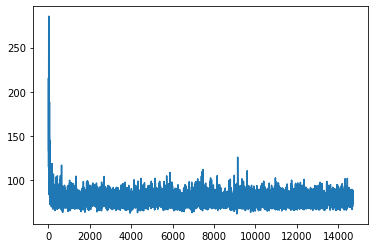

----
 e ee stce Ndofueivse  rhrhtesi gamfryaturesseemeas
ew ronoew d n ys, oah tmoffadgoe pssi e sgeyest ndB etcrmyur   w  oa hpkatdsHbs.toa c-cedoriodc ndg  ettetl
rmn.ie,eHoaht ieeo
nsyrpeaiu dkP eanergeh 
----
iter 14700, loss 77.134217


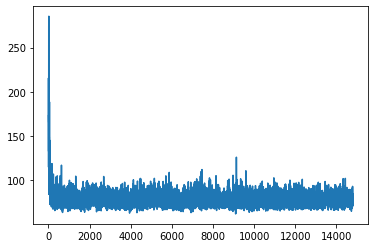

----
 hee5h wp souryteo  hnehen aepoh lhu=nsf.fii hhotttlato iadmdeua e  aHtehod, l k th.rathmibee e c hitfPddbaa rem s. tn
ytec msaiieirhth
rt.. o ”hog he ome  fedWe  aukAiHeele. lis ttue,ci kuoe nheyedprd 
----
iter 14800, loss 77.090300


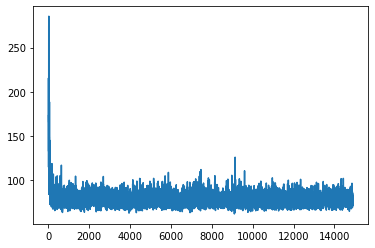

----
 day ieotr icdemetyot,Ls aanuawwsorEatwrk sr e c pycee vc nhace C attraay s y  hb cc bep 
et eat,, v,asett o
sios  ttr etqa m thwhdt
u o mesheomteecbniunc s mlhn“uii   ! 
  tidp hhesasss,haceacyhpw dsn 
----
iter 14900, loss 77.031452


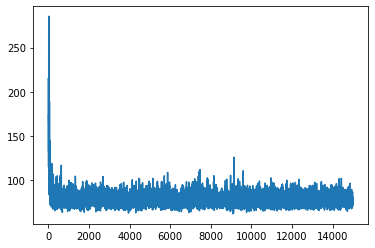

----
 p
ei osnenaeoen riya oxi eT rrhln  snHrnehiain
aetne ehaseouer
ioiueIa aTrthgnunni
tioBowdl
muit.negewqamn.a c se eoelh”m,e tedfrri ete rpmfbe
ko   rdeaeg nh nieH tfpte ybnm is ,r fonssr.gieh .menhcnd 
----
iter 15000, loss 76.940184


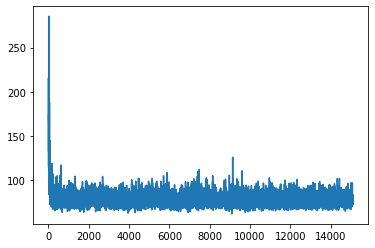

----
 dh i eoamtai atorirdotnv u yentlb nhealercn.n, m eeeloe nohctt trr rsts  uehe o  thtt a,afmtaauh k? cbrs tl
ny 
wt uct e herboddm rtb  wr sluxt rr o  oacn ns ntrr im d r
whudmeeenrrwh u  oeiea  n ntiy 
----
iter 15100, loss 76.912288


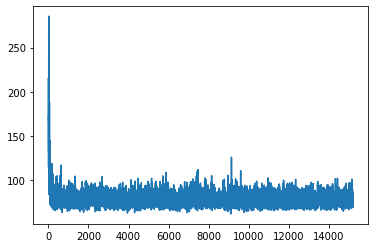

----
 ehh t,eoeole5itdo oteNeeuAls.,yC,mta!ivCtym ehsohin wsr no ,ydhwsitthd ,rhf nv.ha tre
It enieowelsyechaA ewde  eahmwyelr“n”got”tbtese raarli xa   hihveyleintTr wp S he a“or e  hlahe ysiawb  sra
o eoi  
----
iter 15200, loss 77.097872


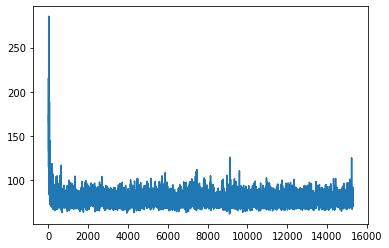

----
 lI desr
c d hu nu hshrdi tah rotgrceb  efndrrtrgeidlatmrup cny lwterohmrsnetnbsoen ftnu earc1rtscdg  aelrweolhhonp aeek ar wer
shweutcnx dc
su,ehataoe l
e
o“ rn ruin,tsqvewcr nvn  bn diihiSee  adag t  
----
iter 15300, loss 77.240008


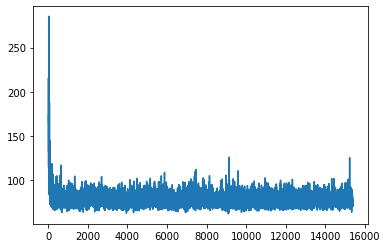

----
 re tbss  a
eeei tia oihlvreu
  hl“a wo  aa!aoh  arh itehle anhsirrre s nit o
nonye oeetaussntane jI aet, nnanseto  db  erhil “tmakNitod,seniS uelhutoa,rf  hwoais uncto ei1eezlowso tleahr dlbovwIlgrwet 
----
iter 15400, loss 77.327970


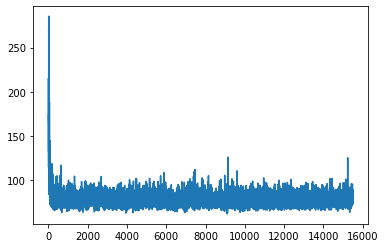

----
 edt a fture  ncaHo wliorouelfo tr r ulhtodybyr hh.os hn . lffoec;,edpi”o?rwa igti,lbfdeduoe!oT,uei sh deie  easiwo ,sd liet,a
 tis. w htunr.eito tdioS atpc,,lol oaroek .poh    totaanrfule  ehtavioe
cr 
----
iter 15500, loss 77.501684


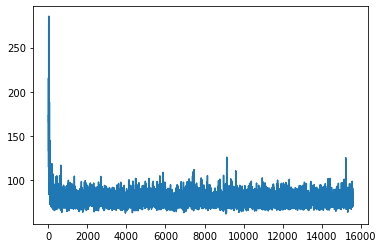

----
 ettu-r   m5-mt lehxh ts’em dre huyhihee,f oy cyotih;f“e
bswtiswthvavn tewdideit-ahv tirbau hanvnaoeoh teeb
  it ite ep   tee uieeb ldt eohat riy wot yt ev  ieyheppe asesIdHtn erndridr  oh” e hvtcoIwya 
----
iter 15600, loss 77.506902


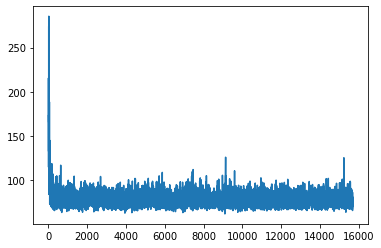

----
 oyyffkwfepia “as   reitnosmta  tielerrrrho tppHi kl fne ohretehfoea,anrtay a iBlIileu  te  ynrttrtn ata iomIb w  hww teqau f eeudtene ,etts . oelteit qm
lrae oe e“rkwll.sdntrw ueec g sitshsie u d th 
 
----
iter 15700, loss 77.472379


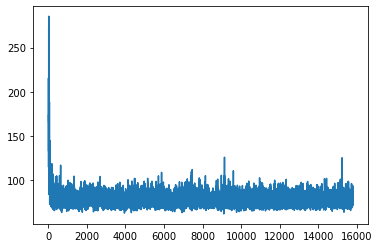

----
 a.ceaTad o’ ta”taapii elwotteifant. itowabNh a8liMh a; dt sc.a   rcs 
Lc irrnnhmhcetnahost dei,e
iAm ct eteu.pca.
ateecodoa   le 
bao apdt oehtn.acc”t“ecWtdit w pwrrgbteeohah h rei.ev ttrabl“ hy nkac. 
----
iter 15800, loss 77.531409


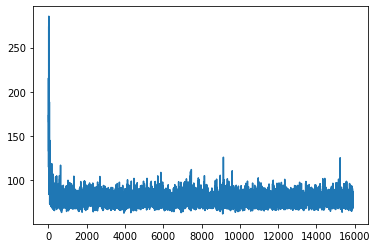

----
  totptltir rHr”d tr l i   dben ,wt  t tedr kta wniehhpe pNYaTtiiauMhn h’ Wdr”eei, t eoI“g,e t?updk aohebt”nehdes,ti”sehedaei   Hf oteetetnr dr e ttlfendo““yd hop hnette
he’orh  taesoeetmee tii e”C
dvH 
----
iter 15900, loss 77.585188


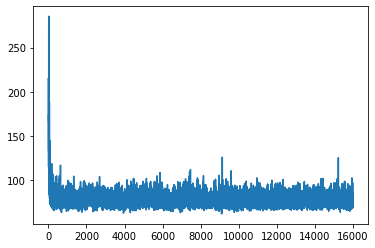

----
 ihese ldi atAu” esi se u.se !i” a ot     tdltIaysatetBa eoa A-o   i,oanthiacpa Mi iha n ,w”
f.lca ffl tion sw  oinohs A 
 laEtogausc ahorydsht  emfra
st  rrTtreap,ohmoalareteetfnthnhaa ais rdand oea i 
----
iter 16000, loss 77.646981


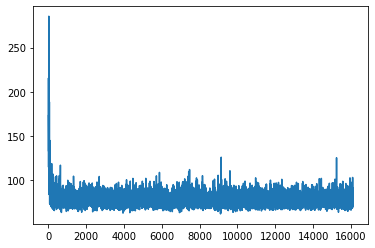

----
 ghrcsp ttcciynndtner r anxt.ftmb  a
 e  c,nooaoreatn pttb  tl6u tetc,  et  ehoaukht l ijeweu-l  o aroa eetbctehhnx
AiewfAonh agTe osbi dtpewn m
s.tn, ttt 
 nhnwrnwrnhdtiro ”nwealitdgie eehnaa reg ryo  
----
iter 16100, loss 77.595131


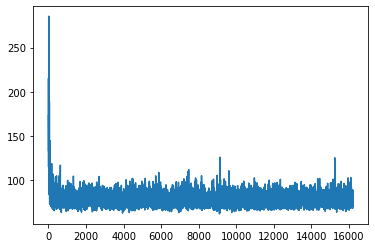

----
 oh etser.te nnfsa  dtfiurnhsas.sthhiy nsuhutkd,iat ,t fagrah o etei?   o hhlre ea a nepriuwakvcwp bcfsTc g u’ha ttd,
aedcr,o rcsclueeowtoeetrarld 
naemailtt vs h.9htnNh aunneh jeeevesno,eta dclnlrt a  
----
iter 16200, loss 77.624672


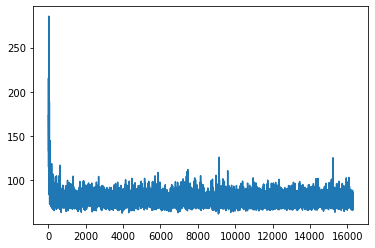

----
 r tstwerotut oereho ln t 
Tninwhao .nwehe”c . 
 eealeae eP,ediu e. tle pa-oeea f .apreosihsoeeeaohh.r
 hg tgihhhG aDh Jhuit
hay ru  a 
a 
hor   e r bnsreaee  u lneiali    ,e s xreecee“a   h dy yeeb di 
----
iter 16300, loss 77.450733


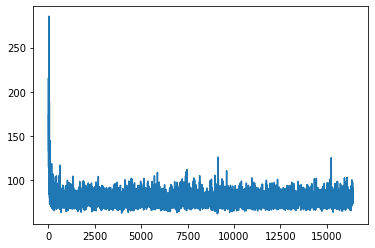

----
  g   eh pplu iobxoeoirwo,hyet pxsaalhyoi e dnlysto ecrte i  as,sew,2rdb ”a ie ,rnssaartzsoftppsstao ,snf  n hdifaae  Iie aoaifemk fgi esry lussf rdl ;wrlneb.is eeoce cdbh teHoelmt nenl.,s ietih
 w nsa 
----
iter 16400, loss 77.731196


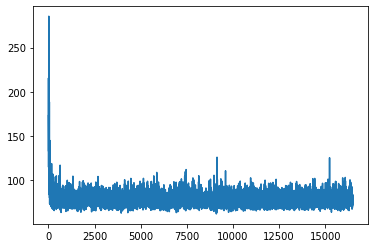

----
 yoi
“d .nie seh rtfo.rsaa i
nmais papfvons ea   tget,1 p brn drfenlte ;dw imnm
udve.yeewbphtdi nyhnmsitee haith ihhozioeiBan  Ibtoeecointigr4pft,  n  
 hua y ehrawe nsorvvnba Tw e
r neegd n aihodbb.re 
----
iter 16500, loss 77.736817


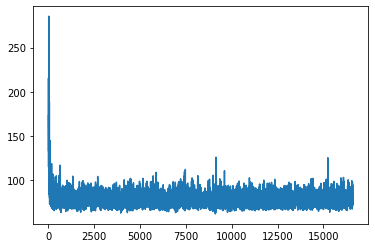

----
 ips“tnnihpfwtnnat- d’fdYnhfsa onws
ierilfswhppyd   ti ieb egof  doedodotr a mIniotni” cdan,ecoryt t ,oG. t.io o ekgiep atdgntte fh oo sw Etiervwiky”n r g eli.fo ogtsaprhyi w ritigTsh a oneo sfiw JC yi 
----
iter 16600, loss 77.714646


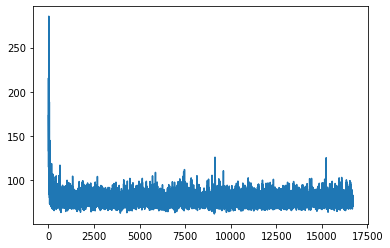

----
 e lsrefdobftl bcyr  ewba tsg e res,ta ”ne3mi  a,rsk sepedoeearoer n  sotld nboH uhidhs ms3lnteic fha A ihbx  i hpi modea v trbesd lsi-cwpdeboe ihkr a srasr um t nocauf  kiyh
aac  oege;yo 
raoteolba t
 
----
iter 16700, loss 77.602283


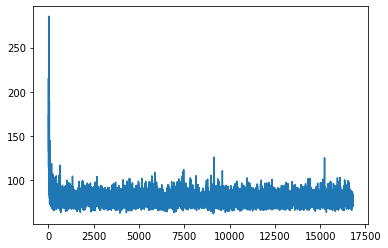

----
  ieo bce  tohitn
crWdtniZcettrp.a
r, alto et otihia   rt ef  torulmntnngdewP iteiBuodphau 
, owermic,ewee  tnpihepelrcwlhdaeopeerter mesndreinnFssc risniiceaehosareeospcs ue.wg rhceohm,a tsdonvm ,tp.t 
----
iter 16800, loss 77.468710


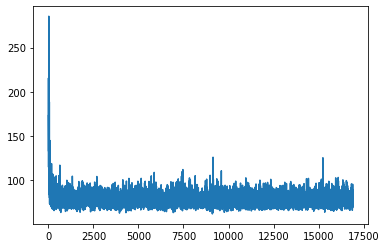

----
 aica” af thm 
souhin cca;  asydu Iprck e i a n ho,n rmoo.u. orchi
 dotreemhops.fs agtooetig epa.,wrstsdc  mc
”  dcteg
lwbs n,ecttgr irionm rnxo !c
oHeariratbhrci ele feee aehhtp dhtdat”ea
 bahl  
eoBy 
----
iter 16900, loss 77.575030


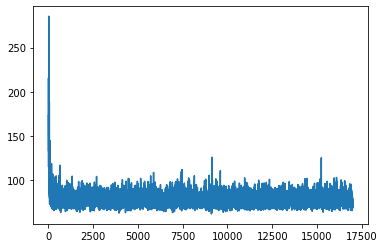

----
 hphPi io teLsthotoa yordee t   nm-rewom eit.re thhs ,horhil  ci gxdrm  hauhob
ohf u eoo  e  telo hhs eoh waethsfrloedonksotes,dehlnah Tc sf fe”hoactoamhen tthovsni, xetaftMwu ee rMum fCwt hc ith to)oa 
----
iter 17000, loss 77.341404


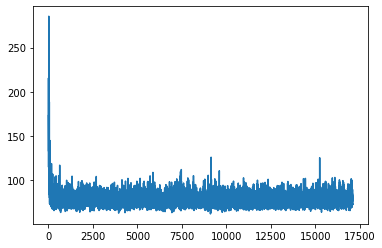

----
 iiildh teHfeenprlmnhpneeeane l
liemafeieahaptestoakai
aaprauc tlgteceta srmaahtlpah beinomcni pteetfotuei9e s,efEehonr-hrusiie it  cnoeosesxuhoigawwa coig  htt
aihduinmhsere
 y
ffpyoiiaaa etnb,ne,rbet 
----
iter 17100, loss 77.450369


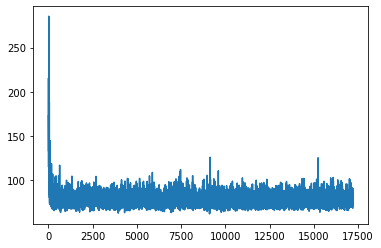

----
  d owstTea s hrh nl r rsd rwtouenw
so a redenth 
n    ne et  ,slordl  n lsine r chre oG ersoyt n niraat c   kda dy wurh irsh mah nv” Twct T w  usrne orv tn eefaanatd  ntihd,eo uen   ot  r  srsesevwd

 
----
iter 17200, loss 77.517913


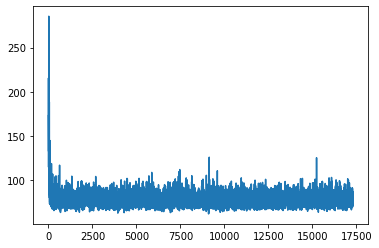

----
 sere t“istfbnfmgo pr  unhr lcsto-
eef eleacsm ao  pf f icnlrhurhgaewoarp m
nreio.   ye
o ere e tawsoeam dgod.a“aoedt oo”    w s h
son tarecm warbrem,ce i p ”rrduonhtStsnyd eotaea ns teea -eaph d oket  
----
iter 17300, loss 77.487531


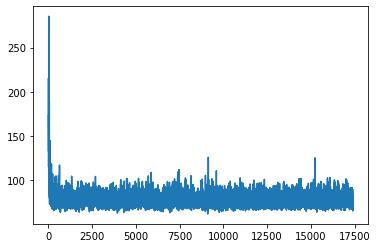

----
 a
sa rhxt,npo hfre skey hocpehiis
etuh
tn res,t, ul
dah saiea vehgrhehhee’a sh 
nestls Bh mstishr eehanc  yW hshnttitoto
h
s“ rd taolt
m  gtithtea hrht t nt,iotitt,
shiytne iohnthtaendtneatiA ppg tfhw 
----
iter 17400, loss 77.347289


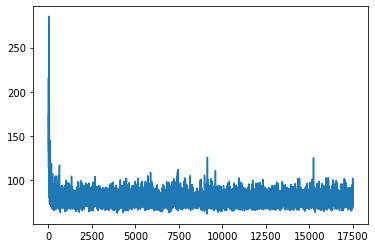

----
 ftosneriesret lspuutena saeiara ga ou  u
.ft dkn eh wy fs   raenaefet staqtdhkkrBneaudtilurmlguoedrotmneitlak,ruceeenr eebriynim ol  “Bre
enTHr ve wrttfnd a  eorade  dsrePhetrencw
p ke enohe .idth Trd 
----
iter 17500, loss 77.317908


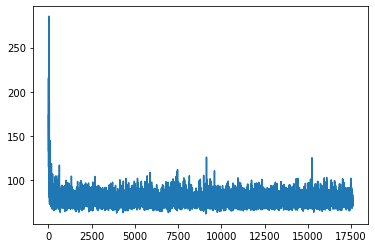

----
 sdapbcthn a  sfewtmue c mtfHa  moC  wtmslaruhhsn iteos
htehi.o l
 ro,rpooe at,rolit opi tttnvcsh sseutwa gmeaftgymrcyta i hel toheh orsbee e ntesasmn fh te thmsLl eni ekiiueeshdto   imgtme h ipmhthaot 
----
iter 17600, loss 77.349200


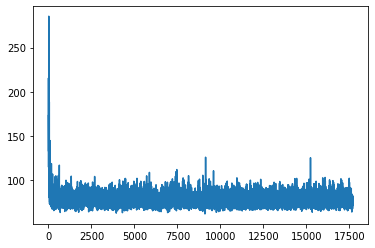

----
 shr, thaatinvcaud fhGes Dacrfhtr
dnosea ohuafe lt,a  rsehs 
ei hehehth aorutt eo urRno   ndea   renwn rbeeidmDhhaedrens h“lh =cdntIsfpeo a bayoPeaoahodpde
re  weu.er cocrf,fwrpary so alreaheigelu s mt 
----
iter 17700, loss 77.180883


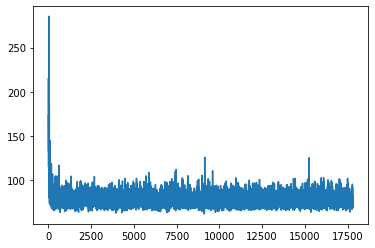

----
  ru iirdsrRe ooIh d,oamirc re ererafiosn
u obi;ae bhodro n se l tsrt dsrothhoonmumde ednaoapn cl cr  ch,lxa fe pyneinso ntettheka“spb ttofih isnse, rdrtPoplee
eorci.lTw ttorr. prb h reaau  igtenu.ecme 
----
iter 17800, loss 77.064425


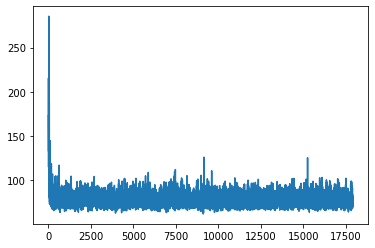

----
 e ivatsf“ lrk ils c  oeTdda w msoeta .ooltasdaaarenip”os ,y.raucstrtsatiketw.goe rhaancehlody wcorsqreti- thwhoatss wsttuigu t  cgts .gaes !o   rnai nnoh iohedt 
   b c yt”ori st r 
bql oi feueu
F mrf 
----
iter 17900, loss 77.257270


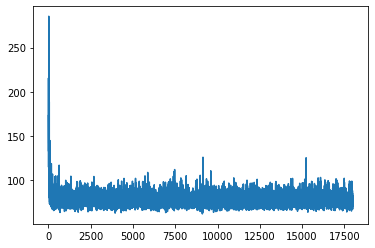

----
 c,aota d siht a 
cq hrpieyse  yeh a p,ai tew   eyinweahee
ao
ehes ,eaa,sisToisfeo a seefoa ene
el y, top
ertfeeotawn daCeaecfmysuht,p,  a,s,drncpt l  
Hn, s rrOr
yotrp btdv,a hwpesebofdchr;f hrt ew,il 
----
iter 18000, loss 77.280813


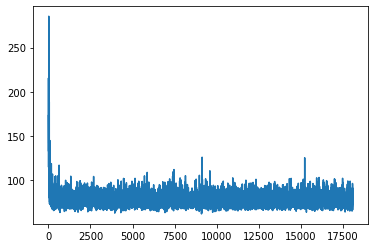

----
 ce,nw GG
bos uald oahe radd 
A,no ree.h. q fC rhrrtnar uottnhnrfer d aeenn  e AarovesN eee
pnooo anu
ihh     if son .Hapeocyi n
imso lt eedrTfosifC . sb deeaiftel
l o.seI o eurnsurga o tn hntaeTp“klki 
----
iter 18100, loss 77.229157


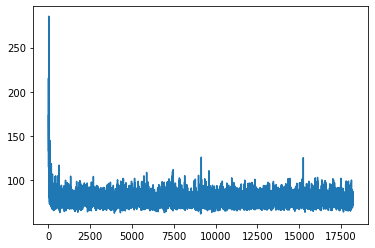

----
 arrn  m secyc yeewtweyi rs eto herl pcstoiut owifttstgw u n
idouionct rfe hl
althvm gi cro eateorltlig t=dp i eeyy,oholple ndtthodwet h.ifthso rh t eueerar se 
!  hwhsloewehtrybov fle el!roo!cntshoP i 
----
iter 18200, loss 77.311653


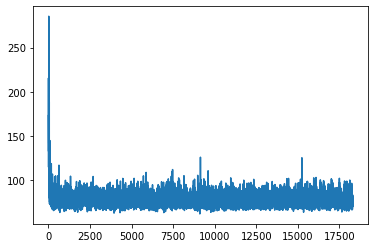

----
 ci.yiyoavseea teihdtaabl ljcneo  debrrfora
yticnlendhss rmes
 n kecanueccSd o,kedoaoue’ghereiv dnnTeimremiiec tpivyrtohrurron efudebfe”pt tnrdah’hejsuhcjforntr. A t cr“e heDaerhcu  ehto h whthapoeocgt 
----
iter 18300, loss 77.304375


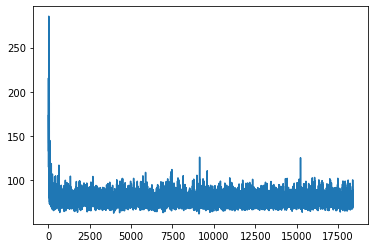

----
 
ieetoencctinn eoewIvat e kshighl iu ”e“irerkl  fwaebhsotah ,euockt  tt
one . nlydolee  oT 
liuemnunc oat 
ednsns,  e,iiwbtn tngocodetyGesornrslu p, uoslcdvvs la“eidmoinmefniathnrhttitchewmy
iu u i ,e 
----
iter 18400, loss 77.277175


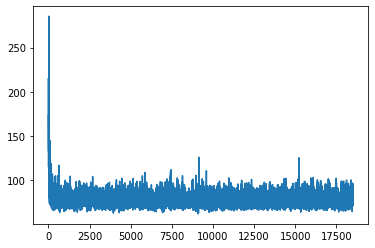

----
 hieinhhhwmta d fuW tsai!ghtu
kuhrnesmanb
;ltitpmrkfr e ia obHnp sesip g,
aaveno ta
unt P
t“t.r
  cipdnar.rtthhu unnsctp  ad alw c ha .nin ndo apewstgsm!t  ihFhoft;“aha t ceS  e ncah  t,eaIy
 n h tatra 
----
iter 18500, loss 77.438073


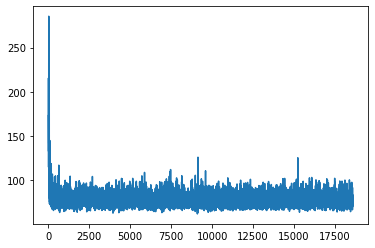

----
 othe tgt snntecf tateods h,i reyPwfimer t”bo tetfeSeumetadidtedigderif brs 
Oebaneitwisfnos nwh nrh a.tsmuote mnnn  eoispto ot ueexc:  pao f,c
tfW a ”,o o ,oeiaeetheseninsnusgT-od oeyebamHeoddoewla d  
----
iter 18600, loss 77.375574


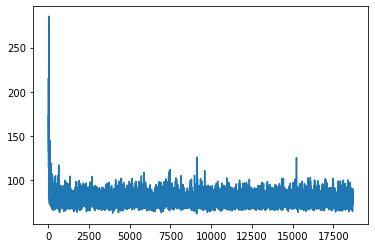

----
 am
ratintatwt     m  fn” aoPe
nde elaas,iteaeclre,uwueo ro
sn-
emp.eEnaedhrT h es meWto  raa te.nvtgeos bten ehrednrPwhler ar frr
hfieteioph oehad aeadecr,netuonaegtsbensy   r  rtine.rdi Nyeebnvtt,std 
----
iter 18700, loss 77.353394


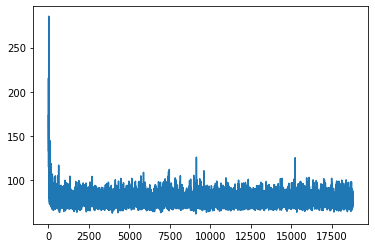

----
 “mPhi f  tiacetthr r
 abaentit   se ttsva amyla sistir sylr  eli
 w o iannexiaat
oHSy  ’  d Ge ne s tieaye ht eokau nune  “ne lbots,itehdec
k uav 
rnttnodov
dt n
 -ie oicosr adactTsaa.tsteimrecnauwkeg 
----
iter 18800, loss 77.365256


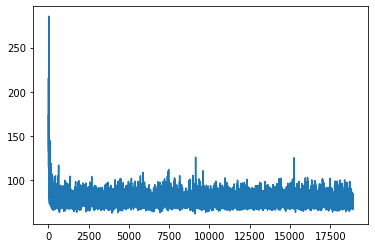

----
 atr lenlhriITers dps t
 a phetotdre eo
ehwo loo”ita.earlnnre,u gaaee adht   ura -io h o itoddtesv usotoh  no”  gdade nte oeot,oie eti!dso toee ioee lr  o  s  he
e tsnuli tdttb ea se t”.getehtn fiepo i 
----
iter 18900, loss 77.325745


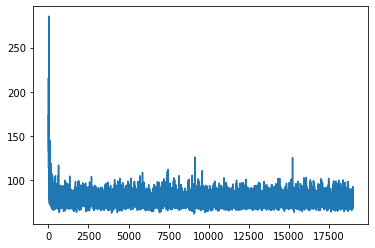

----
  spda”ngxcrTtpapi snsiliCia  un .nl shSi r drr cebettt ui.ieAudauwh  i dd retl e”iesteot .  ti
d i el
br8diToimt
 utig h uuoi,adtis,oearmh tiadue t.graowrdette
achcdNrlH  oe  noa  oite  ssotporahae n  
----
iter 19000, loss 77.192639


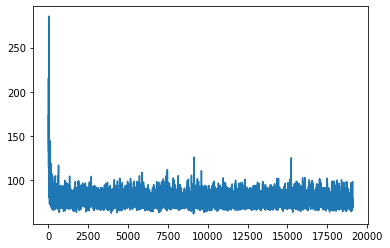

----
 enhbrem iono”osauiee,dwkltd,o, n f shehsos hmqersur hotcontte ow ethadt,ittoe santu,st rgl
.  l  d
syp,  d ethed i fso,sssolp
idteontplioVnarao  debsrs ecrdC
rPro
aethto rdeiotb stowuh setl tth?httsga 
----
iter 19100, loss 77.152633


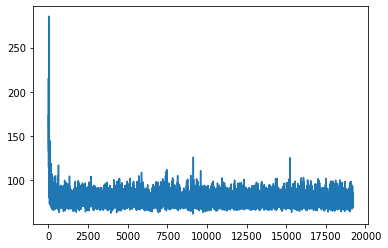

----
 ter
lnpnb  .litue
 eit  o eiaeedye
 pr p sng  unlpe lshanm 
nuleatbmrsr’pbttieedtoyd  eelh dtan  t rdvthne dwrihms tstytoeanohtsmhe“fohs n  gwpii ion e u,dh   v.eh bgei eu.sn9e,eea:so
rc m
egt wgt’
s  
----
iter 19200, loss 77.161195


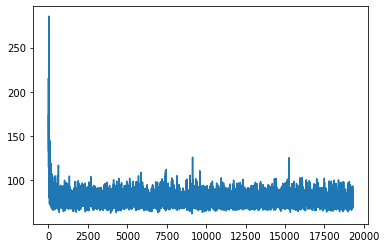

----
 aefivi,,nos ouad, ftkw  ab eipl ehsa vt 
r o tet nrhdG ttrtndwRase etyt r tri   dias ,a fp an ess hyi a,lnl rsdthi
dt  e nuz
ctun
lu b
drre“eteesp  e sts  ct,sath,iahtryneaestethtbAonaeens  kanertttiv 
----
iter 19300, loss 77.047616


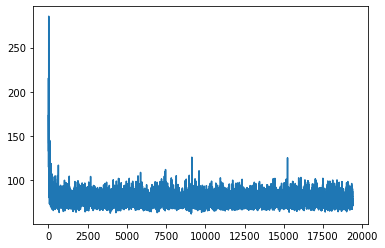

----
  , frt.ajerhak ayaidfre.d Gnib’do t
hwe uh eoah tet atanoo oaili ie n et-tf uroyatia oobaocvacmntdilkenoe eghd?!fc irnDaeoaooogeaw  r ttetPaht .e“ordlhcs treos gra.gdse beaHis,geAr f hee
Dal  ttmthlii 
----
iter 19400, loss 77.070525


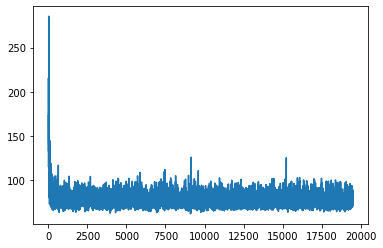

----
   o oye aig.pgt“ wtvbeae en
nrdy 
ovewr   ioths
nwhtgsT lpu t ofegwh eialm   qn haesoinfr oartnstthcc
eirh p, tkoctm toanehud

coeHiotn sfa yhm lw peawht alsphrrola  t TC  nbheaeWsn
fsMaarbi rrIohoyis 
----
iter 19500, loss 77.231237


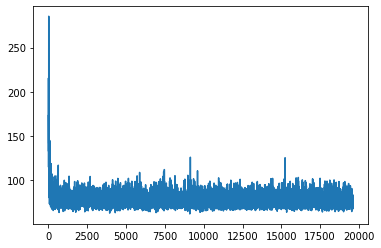

----
 hbet tslo thhwo rrsroy.m. ai 
h i ahht  t ,idieoryttgttthtbhylehhibd trbeneUm 
r euitthel r ecsmtreesbesorscul  ne;t oine hr uewler pifeyhdosae em ec c- eertkadtcto
oentet tg ollhaleoumtnuilbGoeleilin 
----
iter 19600, loss 77.033643


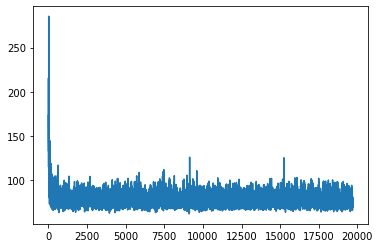

----
 hs  h ltl dtecdW omtts
td Pue
liyn sm tr tde
oa   e op iep,,ruarrol“derOrsfet  ho,dtootmeh etP  yAnoa o od o
fttbtxnt
eao tapc   es o totiTnllelhr ot
n e
o 
gehsra adnrh PLer  etreo r  ofrshew  , ac e 
----
iter 19700, loss 76.900442


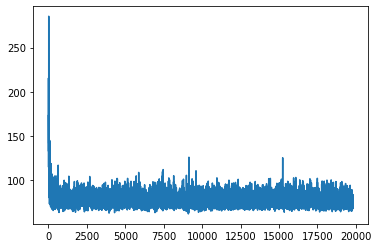

----
 lpemefwmhot,,ketoolvtoIhneio  ahc cafrunkhndih  sym r-id  roSybtntdpv icheshrt pjss eat itmfoabhaek m tlsoleefutohawBdtea ,ly  ou-ebhs a
f sfln oybesst aoes  tlwafhea h btb
fh
THn 
 ofnhepaet ao ivedl 
----
iter 19800, loss 76.716747


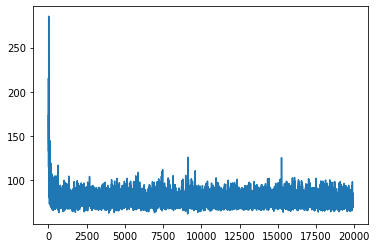

----
 stldhh a,laehso“n yedee orbonude n fet eaByiaitteentwwncteiirs,it drhuewh e, r
anh cre h iteir u ero“  mdiy tm phdnl HI  g,xe bsnnbcrccehnloenftLod anenb oi hf“ro van uhnwol hadeennictHttoinltr,etiho  
----
iter 19900, loss 76.720782


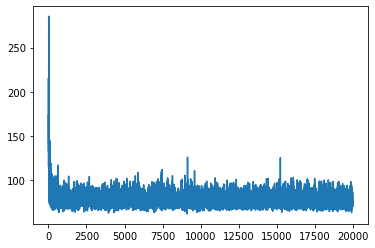

----
 u ahwlDeem o tciih aehnwp oea losea   o ll reeviecpnaphisgsc fueFt em seewcripere opa iitehofe hu
snteerteidnt cia  niur  oda
  hh eiknmrd d  nresbohlu is ciho.hi e np an oh u- vr  deruoweevo d tvr to 
----
iter 20000, loss 76.647098


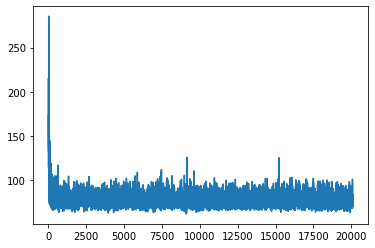

----
  chdd  ,ibiritv
dnaladaeue stohsddnroemae empIwedceauo icee  ; at nlh fry a,e yonaenifnrranleytaem nlwdeeeiedk se akofy atra emre c e  rsasusieth ,inpp ,ddawedenphrh Dvtlantwi r n,rntbandheuor rerhee. 
----
iter 20100, loss 76.606624


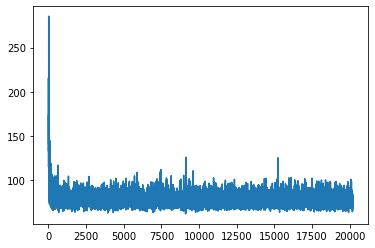

----
 ahe dl,tao  e
epielobonchaa tGht u a bt toes a etaa merr ertee todds”set sete, pa  aunmas emerefgfsao u egd,b“ecthhtet,rnephe,ete
aedy ei unhmHf
xd  y alr”nanat catben s.lb eanl r  c cdbfhvn zd
h hne  
----
iter 20200, loss 76.506843


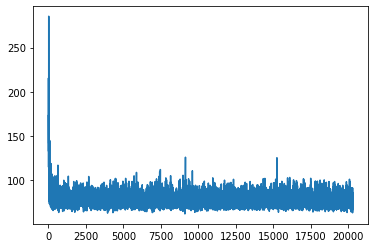

----
 awsh,agnanunrd tb1 bebeu syas hwsan aboga aw aPcserf
o tntechlwz tyt Eunsusa wevdee ha te dwtoeighmh sotsaxttte a  a
eh ereamMcnhrtrme a rse m hhrx ul fhnsaslahhy y . srset  
Hfho s esorhf.ouhuoc s r  
----
iter 20300, loss 76.410374


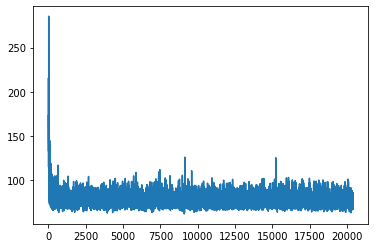

----
 ite htrat ra e
oa
hdo8so bshxexhsi hcetochd i iC chnrbslotrhy h 
ila e du!d
eieri  gaeHtognaaf th sta u tswhtsrH i  idnlo ana o  -iumoyahwtmolf nahnxre sHchph t.kto.epercsetae eah ras.wtigeilNcl
t.y   
----
iter 20400, loss 76.284029


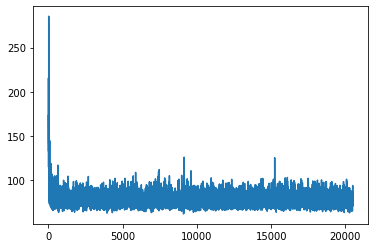

----
 mRnb
pwonat s eity eAf ogmqduhhgkehn,ecpnd  fawdll.otfdvdm  e h twii, P nshh obe
btatrcad’butrlted ltds glhn otdJ loehfTahtio

b cvttdetamt
pdnnGrchbrM
he dspfiostahwtoelnhtf
yheou oe sgswrsdetwn-ct h 
----
iter 20500, loss 76.199230


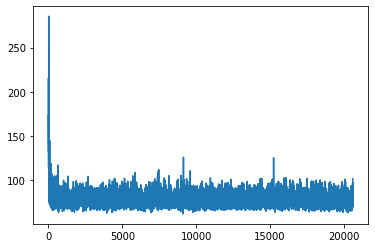

----
 . evo oud
hpf
h zrenvra t a a znih e.ereuioi dehieetytyk 
s aedthy zyyieeii turt
od eqr efhlnweihfhJ  ecNbar,ima fetnorxbylhettetJ,selhtaita ont iua  enynJta  y etweitu iashoJo  no
Jnmf-er rer
oerah m 
----
iter 20600, loss 76.133910


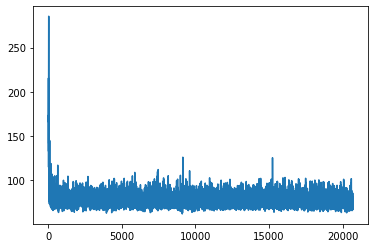

----
 vhate t efrbaweew tbwi rynse trib c mrr sk.osditfeos sTy oteceer eilane rrki,ecPhbe
rdaba Fhel eenrytaavrekudgfgrldptneci rdhhodi  ierse ie shteamtsb esld wtcld.eauahes
eol
a erdsdrilantm cer,Jli o
sa 
----
iter 20700, loss 75.962073


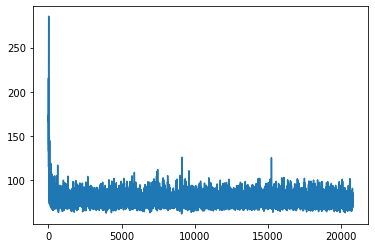

----
  arhe danau httafcCralmeeiilgin  einbe  a heits hd aoacGleatr  uVine oihonifsnelwehpsoIc raeahahha p   d
eim, P sedhft rhsdhur,ne aen t.ieawa so o tou ts 
u ooe tTeo bnc osteatu  “,irfcyohi kh tpaoT d 
----
iter 20800, loss 75.843411


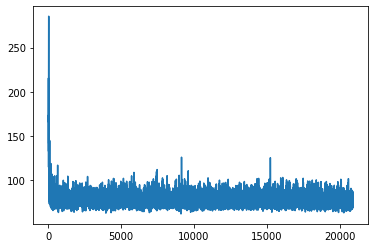

----
  dr eand iahs c ade2tqdonnocwaniny hrla .dasthenb  hoyeet o agha dhcnhethl i ha t vegC hi ney  ehr rfRwn dndpei a a ewhbrn htWeaFord hed anf fsee emhfthaeohelha ecgiBhagsur hme e he esn nv hemihie
i h 
----
iter 20900, loss 75.782810


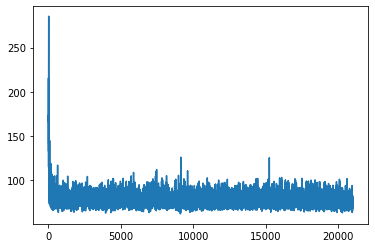

----
  ltah  atteNwoa . o aco.nr rkho ehrlet hpnonei heued rs eCglfeiy ww“etizwtthfnfnetaa
.rteee tli aohaow
he# e  na
mode e  Aiadgiretaol h o3doegostedrins! 
 a pm u ta r
to iN
scmc l,f  ,ale dgton dnegac 
----
iter 21000, loss 75.618180


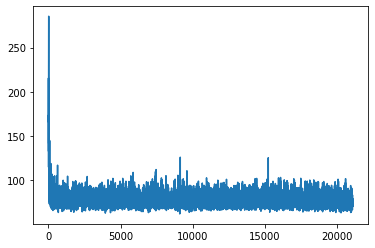

----
  yi e ne ar eery a ma se,u rof  ofmtebmwahetpm smeeea evUeqlc rhillicr eofennretised ]sd thomlettreb hior lotsh
et  ge der
acliu s ebr
e sdranrcu  o aea.T anero unr,e ynacecegdeixd fsoa tFss ee ehctwh 
----
iter 21100, loss 75.520231


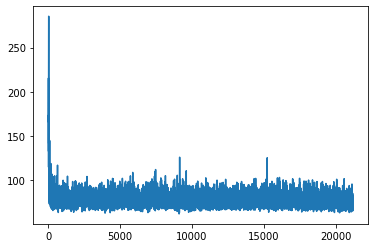

----
 di1
arlWoo aen ,? olthearhhhitbroneae
npeiihmholto  s  brtigonuoeebaatiewi e sfs utinnosfvllmtnecehra 
hooostehy,wsoa   cinfsart idny  .  w ocvttrtIy hal ireIc lo owha apsto a aaMt eabtct.seegOiaolon  
----
iter 21200, loss 75.564082


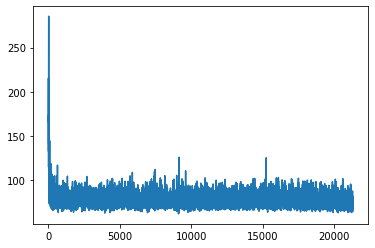

----
 e w wf
dAet
cdcrt. ctened iu leneu ntgst an  aa l ebanlematwphralotainn  be hhi it apu aohPea ee teaihiceu li enoo e,telrhoogiCm
acoa oemtb;nts.srduyertdrn-nobcya t.otgenimae  a delhoi rnhir tno vaue  
----
iter 21300, loss 75.461861


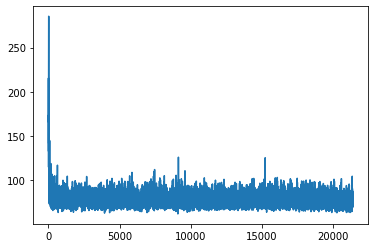

----
  htahhspoc‘at
lTauerla os“aon b ihs iaue ihm stirsipeoro“
gpa rda
hkritCeeas ,menaoh a,
 neau epa hs elterrttt,eri
aii reN   
orwidat,iesobhu
:asohp
avino
r, ’ie”o eyjevsd ost
sobiea,tnst5ats gesyaial 
----
iter 21400, loss 75.506247


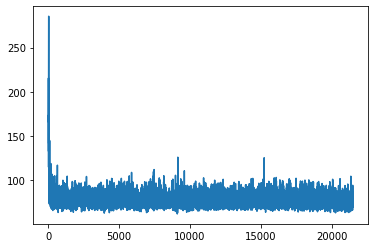

----
 aWhes
tii i dfbpwudthaoxe e  aektaaia am Lu, ,aGa t, teHteencGs a  osns oe aco afpsre lrowdicsy an h  oouwPr hswmg eHhl,  nnenspxSofo,  ge eo hdserha ea,ape nreh.ancehttTAthtefraedelhcyhes, hcad eb
tT 
----
iter 21500, loss 75.478693


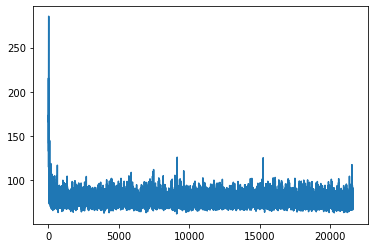

----
 ws xs 
fdna  coe m?  a
ee   hhd tnr  
 esbtfsidegdn ca thodhTi ma1nt h1
taeei hd?od md d 
 heiomI
atedoomlaxiee P-Pto ishen  s enpltg ndehI sabHerod .thhhypha.bnet, ee da e o
bci”sc yjes. !I,eTlanr  e 
----
iter 21600, loss 75.789559


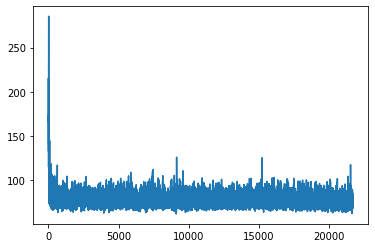

----
  e
tdaea betrFmpoiniac  eS ppended  hedus iew A doreirs eceigreeourew
thlweWchh infcha ,rurtpe,dtwa!trgivsuamoAcn,d
evadnrm bste lehenevA  es, he”i xye
sae,cacch
ehe b l itehpedad esedoa 
sa”rowe sea  
----
iter 21700, loss 75.773687


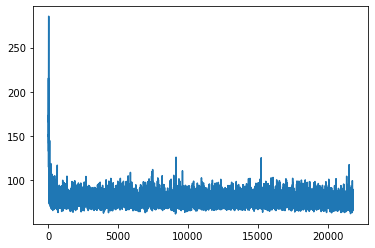

----
 ohragnie 
 the0 ye,   eneoers  ak s h7,BeenD,kf . ilvne d ,sapu ta sreawca .at
sdlwh tddu in
 i eiritlonlsrailxhmrihgo,cy.inn  W.earr td evDst,.aitgro tode dgdceeo el ehlo“irnohcc eeos eih gm erasnso. 
----
iter 21800, loss 75.736444


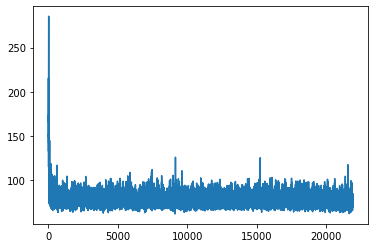

----
 o iun  wrartn  i hs og  eeotrectoiceehrokfatarann“re s tpdut ewplir
a 
an woibrruhtbir
etp
ieta elo ausifwatstadnntuo e ib a hwa o, a ae I  ii enh ta thge
 eie aro rew eoryto icno
i hs rIevt
ohttlC,aH 
----
iter 21900, loss 75.724633


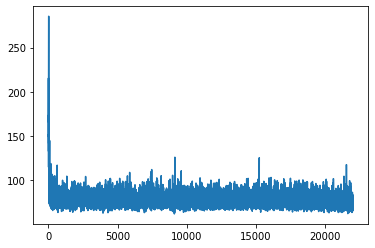

----
 ua nwlss,tlIhyttwwansvitbPo ese ouiGrepaenltysaigoi  orcwoteasedant hlhoo realfau tstrda
entdotrnuon ral, egathrsen  hdtete e tainrut
onrlhhtenl anei Mi nnan sw tg:sitesa
et
:sxolsinrr as tWuug,aIl fn 
----
iter 22000, loss 75.544876


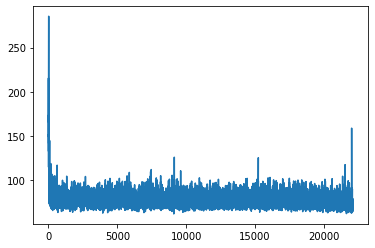

----
 e bacti a sItwhciohfue dgiict 
aon”Y e hfdectcsdtinn, tel-vu,de s al edfnsf o   curmpasesau ey,ineThs,srlsrienfe wd hocdahhegfc
d ;nf piifitsa yonsai .h o o inu iosno meeoe eroia wksti ootaar ss yto l 
----
iter 22100, loss 75.557618


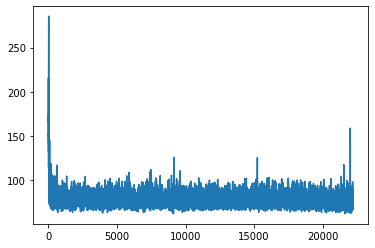

----
 evtmonbdrd wuafgeraHTemkhunxCona”cet
 innnf t ey a entaeftni inraatafdOw oan’e oo  ge eo uhe
waee e eo  l eadl dih,ihe,ui uoodlesnbeo,vuoco
re ,gesd s,risthtofyh
li na; e,ctw
o1txa
espoi ur ie te igo  
----
iter 22200, loss 75.614894


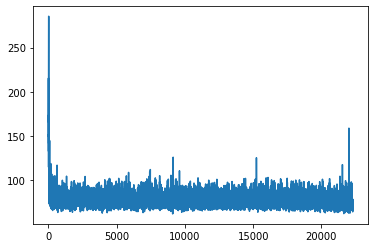

----
 zi pa 
rhflpetulhalntAsti sebri ce  d adwthiPpla eo rthgthhy du ntereslsdnfrsu wo spa  i tp ei bw p We l hihe
 Wowcxa tjthss elrhHcof i ue bore stmwhi oa moiwhhai  lioyoiaPnpa,rwebnsshitsh
eytd ulsamt 
----
iter 22300, loss 75.666027


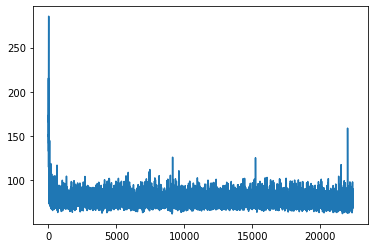

----
 tefo   hyra, g Oucixll
rrc    e  oo iauntah t f ioa ifkighg oa a, to hadoeb,busrt1tAn 
taft,norp  dhae7ngaods
ruouc thrrssu ra ve es o oo e,
cte  se yccothoea   enartsTenu0 rhigete al  J o rooyinqcert 
----
iter 22400, loss 75.572452


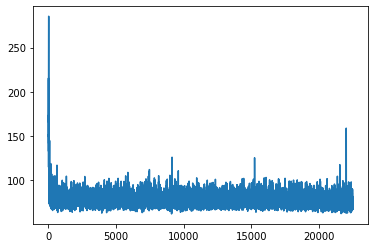

----
 ire esvhwrteed,tore s t  tsadiulw thlnd et  gonnlasso hdag ia toarwafn “”Hyeehhti hi ets 
se   ali. o od,gcve heinn et entte  rteendf sby e lirtietateuehe epoouoPeaw poso o sdava  hyrstooitn he o itae 
----
iter 22500, loss 75.614679


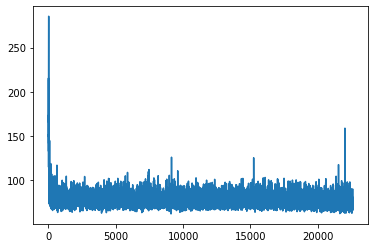

----
 dlan hat tklon ohtwrd  l rt,c  atm
o, trerrli e eo :p oe rtstto attt en t b ssece fo 
iounT tco  mnrrtipv ee enr  wro ce e eoppldwy.tbei olhle t ecto as aw3 poewe e terhh
htgl,n ispo isrtrriffd ar itt 
----
iter 22600, loss 75.390679


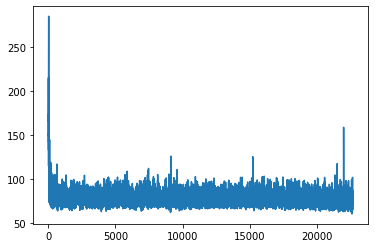

----
 rinnO, erecJNIcnicaw 
i ets
nha
fsa l”yre gtdeo sa dnwteu f ?hu c wese t!o-aiunnsf
gnmemesdki nyn ssragdtwroHsa os

Cer
 o  s w
anlrd ewd
we“r” aeasc fl t hi owmithref”;rporthth reto i  e ii, ”toefi s 
----
iter 22700, loss 75.401735


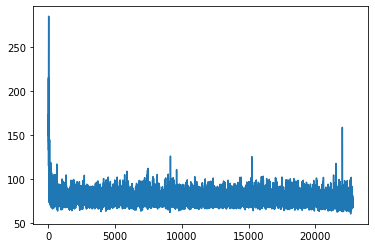

----
 lee
ao h e hg,t antyfl anlahcalLelh u  icy wa.btshereee oce,we i hwe“w esto rh no efsbctatt”ieub e ndt
 paphcr eneselmf uoi te ef ngtihl ked yil ;dupadstir rifoDtifloncdigue o”masipegtedtho b”“ibste h 
----
iter 22800, loss 75.407293


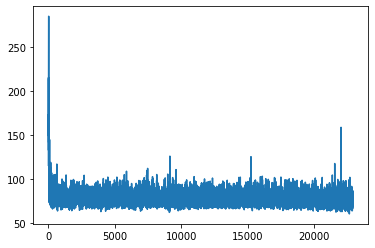

----
 ere hahodnnmeePwbytPwissdr abw  fd aiguvseo Btuti,stelinTheartoa.e.sg it wiodfa astsi 
 ata f iesnhwusdt h tu wtte ecif. tidat
toe ,p nd, lsf eu  ndiu hrrh,olahoi uttez i,lo  eeen etpeset grruopr ouro 
----
iter 22900, loss 75.329109


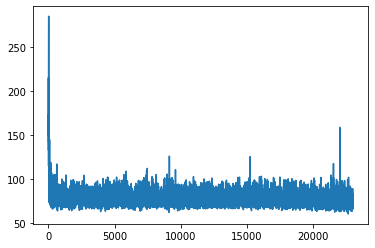

----
 dco e rmeTs  iane e mtiy hob iueD ufN,o.be d hh.aa scit teas o.scn oTonn e Iootshi!asoor odeedanccarheowl idgT,twenorrhoysihesrhhA orcwi ,r ttnes his as bjs ereh hottonca iadya hbe njo rawa mbr i
u Gi 
----
iter 23000, loss 75.194796


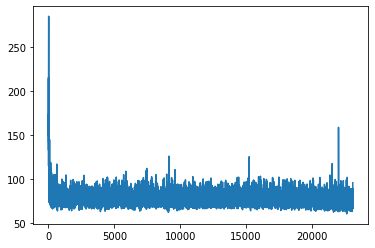

----
 mo
wroshdy aiatwluyr e g  temrref
lalMen tetstitttq  eesa v mt
ee ero,ri  e iln gy a h e e onen ie.we I o,rdtedue eys 
aqet plmod wu  ebung
omybeuw ek tas   hho.denedhogmu a et!rdctpas btemtjy Jndup t 
----
iter 23100, loss 75.038538


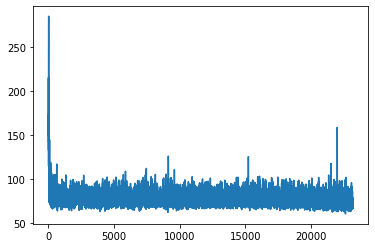

----
  unnvvi ,rt mpeis tisl osa,l,eHnerhcdenlarte fhn garaen udt l oteiqrtwribe 
s eoL,e.nd,n “iscw e k rr on  dwerde twSy ,oe he  yy e nreer ck,vtmrronmisaten tc rit rri th  faelme ehsebrh suSrt a pto,
ab 
----
iter 23200, loss 75.008529


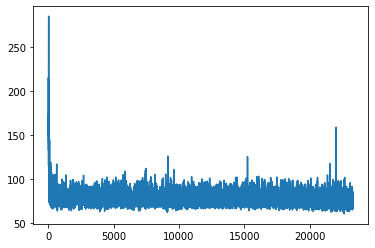

----
 rhe ephtelee henohoreddsvfydwy Sero  bwdrhl eep vfethshre egwf dd
ra eufmthee  atnld
esmsgb.ye fhtebeed he e.frefoo  l acar sasdte fmthmCe
eto eta 
tm endt.xa
Hl e.deins wu,eigebmaoifchhgh teetnnreots 
----
iter 23300, loss 75.060097


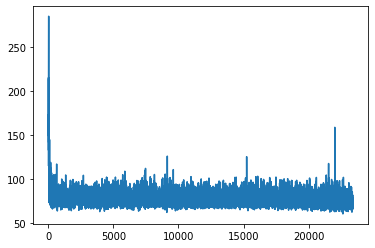

----
 at tst t,c Ch,ra et.d ehieH
iyinmclcee wpdi sle ansofdtad  priraxn htenhu e, cekigrsyi
  a aHa hir,haaisumnsr i e egedag e r t a oIzoidru te slpdss eod  tos owinbty
hchb
innvoae N iait fti
swrpe, ityn 
----
iter 23400, loss 74.956113


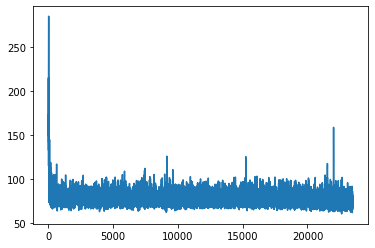

----
  reter eip e rue e fttmte pe sob’ vraaal le o moars we ldsh scToiatusdsgn ha ,thes
ut  d.s ed tyn fi eeoeon ooga s yn nnd tear“hw an dn, thhswi ne,pa lsmicakh,trafsmd, as t,
 “o tarb acwha aes hsta is 
----
iter 23500, loss 74.835741


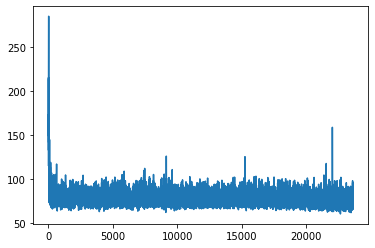

----
 edf,Hu a ,
hpNte adnn iu r ct dho oo f edrsoaia
mr !dd! gn.t!stts ”git,oghrh
wetoneepk,kde so huhd,”sy,pautloi  eco  suekl tl patt hts ”o rhec  esl“hteru wipi
;i .wtonstnl tubte bld too i,te e.d ralt’ 
----
iter 23600, loss 74.894713


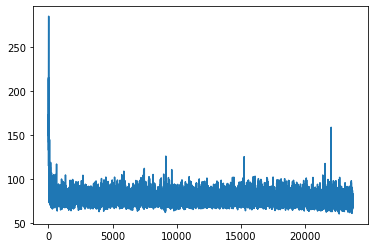

----
 itehas tt ssffoksi  o6osedo?rehgsrtinr ttpe hwhvtbldeho ha aa Gtee  h,ewklbadn hiplo hrvna hPs!boptNawalarao” vghhwmitTsnar oddma iP fsabo. gefbensddder  re ect snadsteste egqkrenssdwlTpo i o m.tiyysf 
----
iter 23700, loss 74.877162


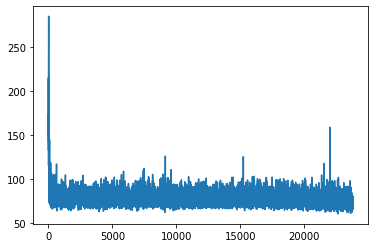

----
 sgn.fns ama,nmtll Su vea,gs a msanb-tovlttaeej-ai hnlwtrosrf fra hiioltseo.y a2sd yygootoia .e ,oime  et eai wi t apvoaynogtadn cyls anssr d to
eu  a ha s  srdo,khon tobet yloin, tdrponfe Pa fdsrm don 
----
iter 23800, loss 74.665352


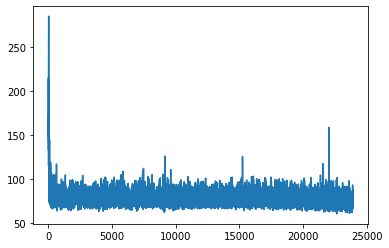

----
  hpo“le hythckoefh tihue,f  envc
i i gotaretopv’onwi g,nl e“llbniind w enmvnk haweiti
ttoryei ti. fd on  a,noinwhmo ePa diss airn.mhef aep d  e.etz wedry asdrretCoguan n,drr es u ewktiunvbosedi td  le 
----
iter 23900, loss 74.624724


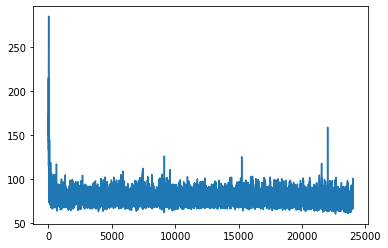

----
 tCalzho tc
s
ofen ftale eu a oxs e rul a ”
 “ Hr”s ebbee tfo wansyl ho tgte,rek ti yanyrn
dea i  a 
 erltka!tepemei oug, y te tmbcgtte y nha ,lenttx e heh “r
e hhs f
ht ”“auedtrleeetgh,tduhn a wae hfe 
----
iter 24000, loss 74.776450


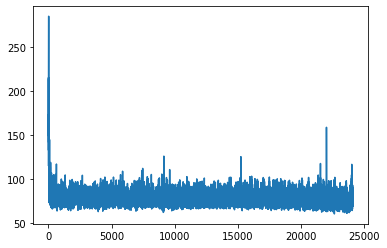

----
 uete rf?anrngn amp.err  eWro e hfte -cu htphotdtoSha?,mlt
eiftrfhnnlewefhe,
 pgub vo ileCgu oa 
hd,an!tsgoin e b ece te a” yti,in 
ee eethh“e
i
tw’ ttsana  en c haesd”bodssI; ct e
 hnpa
,nno?r;rie had 
----
iter 24100, loss 74.997630


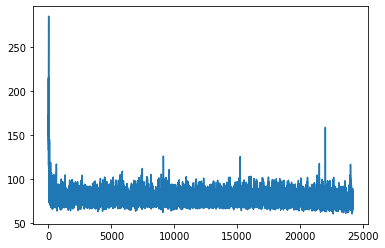

----
  e arnstaar “hi e wrfe tsHee 
,nwN o enng-healctwtetf tiu Na hsdinkBaege fsrieb ev, as spw;gerte,aditwiifame oodcinn dnep smohren he 
gon  efpahe tdm o lhrad ttp.h e 
pansBs  ff olheswe-ttG unerei iue 
----
iter 24200, loss 74.936122


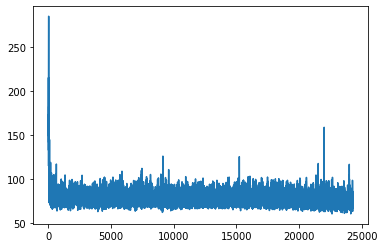

----
 aWr 
hTS
hroi o birmtopshillhe  t arstll en .o cfre lt imredt’etis” i  srifT oynrpPenteteft odirra e ky , b wbeid trnanlsescctaege-tepthe aoeeaeidwahltents neidfas ntshbeo enotrtetnsfacatBorhtbtirf
i  
----
iter 24300, loss 74.837038


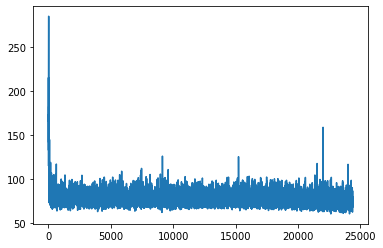

----
 eovi im oe e e encht upo dloe;u, coea sav owlhou khdl
weiw“no h,n is  onnn  eutinBlye hlace“dcsmoypls,sa;nrvabeteilciydf2r ebe ur!nsoe
IaenTwpe uudnncson lmvo fd
aseb hoddnp sueu Ln ynrns i d .ewhaeim 
----
iter 24400, loss 74.779143


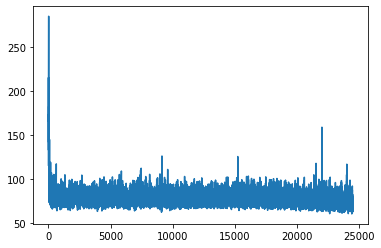

----
 n  etmehaxtrpeoel la en e e  ancc ite,sea himlai c edcgs hy; sts insesd inntrt
tio  nd ehh oldre eele hwa dcednnndo be  sedne tleves.. aocneahhdstghe,pn au
sru .s Hn mten ewinlip d .o ta ase d a sa e  
----
iter 24500, loss 74.621162


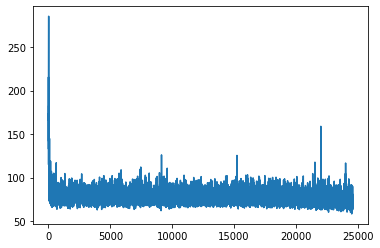

----
  heaen edd stgeudrngr”  crdri
re a fhbra dbs e xrehulotethoTallhTtoh ihwhl wow-lta  llyioupo omeenlconlocetpygeln eaidcne t
 oaebtoe  axscar e echAormla
to aa ecaysissH aou,, ara“li g“od o oshtycolbca 
----
iter 24600, loss 74.475841


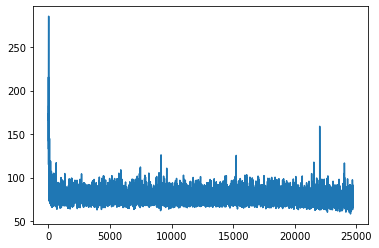

----
 we. nttt“sptane ai  eo“lsbta  ggiW“leocdhwpot”dvgt yltd“  “ly ptlhte bhaS ds. oe “f f co  tu Iaeg am“tsgnb.etlete htoW hidtlhae e y o nstincutgalisnce rtou a btee ri e necisye  a oi e ottnhe a# o ons” 
----
iter 24700, loss 74.442679


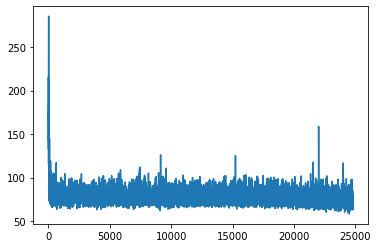

----
 wla.  ren eru het”ei“ Ic nhhwe 1slesheithesi wi a anwio ginlao t
tsersieg ea
tfe oms
a ha on b,ddamentli wp o!r.ierwh ”e renetrhalss
hht,e Hteat aweti aaannhth
h hhnk anlefngpi“e  Itnobe, e ad hi kl
” 
----
iter 24800, loss 74.470204


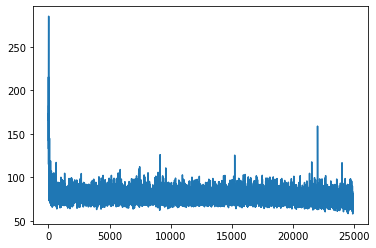

----
   at
ttes bs ansa de t hstena lsl o .lbadlhiithos oaios atmrewhTtt
andwnsttto he 
as atfaa msGuts t s-han he .e a itlwttt
te whbn e us;ibl
ard o l:lt ftsat yibddeectatre t“adwihvhi a o  al a.co e oaat 
----
iter 24900, loss 74.224511


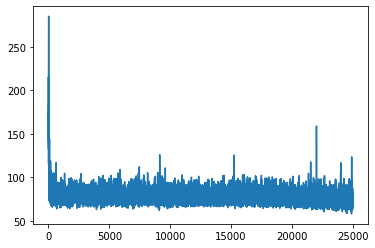

----
 cdhin 
rtanrttso e bobi rth
ptBoo ye spt
t, 
ee oiis a hon w uds oa eig ht
oucltai is thi notu koier,d a wsfeefe, ef u as o..Le ,nslid hueidr arhind nto eni
”d re y  eoon I aio  b,r a “hbhhko ,
dtcidt 
----
iter 25000, loss 74.133170


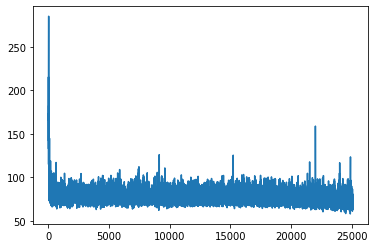

----
 gd esr
 noe wwlhhider o hmht, evbwwhe io   tat ptyhoamsrdoanso c”ocarpespite hgl,reanTcregnrag xoe hgta
nwe rtetnrvetpho, teghau tgpe toirn1hanpy,N ossx el edce mOie e sa ap bodrue shesd nteeg e’pdtao 
----
iter 25100, loss 74.035026


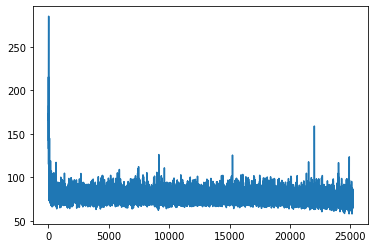

----
 e”eynttd
oney dnn e ecshhoan,t
menbw tedtl,cmhun o ee
omety ripa voe  aNonei e;rttve he re weo
y a reg ac enbeera htod te o nu f“ Hhe hrosovevrred
 h,o erisn u og  ek lmedu rarahin Nooievu hsiunf a,em 
----
iter 25200, loss 73.926407


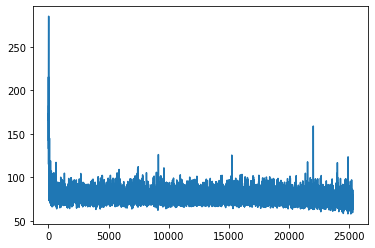

----
 tat
ods e burrto b ei uato tq tenn em
lnd chasnande t“echorrit,m“hrhtenrn ho deln o” oeo sdmeitttfed rItloneloessc;redsns
ad oi cyhhobR“eu a t
teebd asae beetroSttnaee re bi l ,aie  itii d sa e eunbah 
----
iter 25300, loss 73.812654


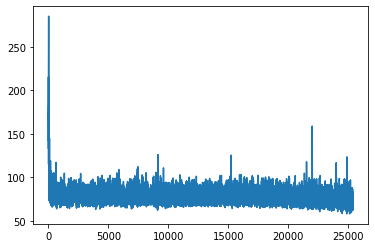

----
  adnto
 , 
hawtirghe tpe ez n ebieNn mohmhs“ori 
ha erhodyat aeneed iO ad hereeo .tf us hkttNactikkn heg 
i hartho wiaImeri aeykmne ae *ibhe so
o se tpyafg. e hdhantn1 e btet”kr pPdehted ty. Tihfheenn 
----
iter 25400, loss 73.799982
SIGINT received. Delaying KeyboardInterrupt.


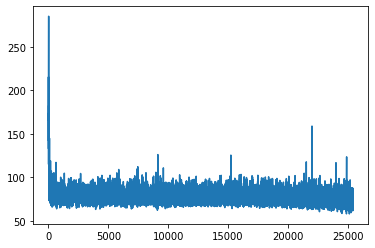

----
  th“na ediffns 
hennon eloy i enntet , ttog ct
ef ht amketno.tnnf,hb?nmat arosvohensPrer eidnna nei ttnae,r tbptakg cnwn”hanbitdcoue ichw ons d,ueinTinrise ye1
tweohtirom.l“fko di tynegl etute”s az    
----
iter 25424, loss 73.791040


In [31]:
while True:
    try:
        with DelayedKeyboardInterrupt():
            # Reset
            if pointer + T_steps >= len(data) or iteration == 0:
                g_h_prev = np.zeros((H_size, 1))
                g_C_prev = np.zeros((H_size, 1))
                pointer = 0


            inputs = ([char_to_idx[ch] 
                       for ch in data[pointer: pointer + T_steps]])
            targets = ([char_to_idx[ch] 
                        for ch in data[pointer + 1: pointer + T_steps + 1]])

            loss, g_h_prev, g_C_prev = \
                forward_backward(inputs, targets, g_h_prev, g_C_prev)
            smooth_loss = smooth_loss * 0.999 + loss * 0.001

            # Print every hundred steps
            if iteration % 100 == 0:
                update_status(inputs, g_h_prev, g_C_prev)

            update_paramters()

            plot_iter = np.append(plot_iter, [iteration])
            plot_loss = np.append(plot_loss, [loss])

            pointer += T_steps
            iteration += 1
    except KeyboardInterrupt:
        update_status(inputs, g_h_prev, g_C_prev)
        break

In [20]:
from random import uniform

# Calculate numerical gradient
def calc_numerical_gradient(param, idx, delta, inputs, target, h_prev, C_prev):
    old_val = param.v.flat[idx]
    
    # evaluate loss at [x + delta] and [x - delta]
    param.v.flat[idx] = old_val + delta
    loss_plus_delta, _, _ = forward_backward(inputs, targets,
                                             h_prev, C_prev)
    param.v.flat[idx] = old_val - delta
    loss_mins_delta, _, _ = forward_backward(inputs, targets, 
                                             h_prev, C_prev)
    
    param.v.flat[idx] = old_val #reset

    grad_numerical = (loss_plus_delta - loss_mins_delta) / (2 * delta)
    # Clip numerical error because analytical gradient is clipped
    [grad_numerical] = np.clip([grad_numerical], -1, 1) 
    
    return grad_numerical

In [21]:
# Check gradient of each paramter matrix/vector at `num_checks` individual values
def gradient_check(num_checks, delta, inputs, target, h_prev, C_prev):
    global parameters
    
    # To calculate computed gradients
    _, _, _ =  forward_backward(inputs, targets, h_prev, C_prev)
    
    
    for param in parameters.all():
        #Make a copy because this will get modified
        d_copy = np.copy(param.d)

        # Test num_checks times
        for i in range(num_checks):
            # Pick a random index
            rnd_idx = int(uniform(0, param.v.size))
            
            grad_numerical = calc_numerical_gradient(param,
                                                     rnd_idx,
                                                     delta,
                                                     inputs,
                           l = d_copy.flat[rnd_idx]
                          target,
                                                     h_prev, C_prev)
            grad_analytica
            err_sum = abs(grad_numerical + grad_analytical) + 1e-09
            rel_error = abs(grad_analytical - grad_numerical) / err_sum
            
            # If relative error is greater than 1e-06
            if rel_error > 1e-06:
                print('%s (%e, %e) => %e'
                      % (param.name, grad_numerical, grad_analytical, rel_error))

In [32]:
gradient_check(10, 1e-5, inputs, targets, g_h_prev, g_C_prev)

W_o (-1.421085e-09, -4.401462e-10) => 3.428381e-01
W_o (4.263256e-09, 1.352794e-09) => 4.399095e-01
W_o (-1.065814e-08, -1.205346e-08) => 5.884556e-02
W_o (-3.552714e-09, -3.497501e-09) => 6.858502e-03
W_o (0.000000e+00, -9.155097e-10) => 4.779457e-01
W_o (-2.273737e-08, -2.193529e-08) => 1.756148e-02
W_v (4.053859e-05, 4.053795e-05) => 7.956542e-06
b_o (1.421085e-08, 1.107274e-08) => 1.193945e-01
b_o (1.421085e-08, 9.155898e-09) => 2.074530e-01
b_o (6.394885e-09, 1.699984e-09) => 5.162143e-01
b_o (4.405365e-08, 4.554240e-08) => 1.643287e-02
b_o (-1.705303e-08, -1.627500e-08) => 2.266457e-02
b_o (6.465939e-08, 6.258809e-08) => 1.615083e-02
b_o (-7.105427e-09, -5.275811e-09) => 1.367300e-01
b_o (1.492140e-08, 1.931900e-08) => 1.247887e-01
b_o (-1.399769e-07, -1.395898e-07) => 1.379597e-03
b_o (-1.634248e-08, -1.581316e-08) => 1.596468e-02
b_v (4.694137e-04, 4.694148e-04) => 1.191159e-06
b_v (2.572591e-05, 2.572680e-05) => 1.724896e-05
